In [338]:
# !pip install lkmeans
# !pip install networkx

In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.metrics import rand_score, adjusted_rand_score
from scipy.spatial.distance import pdist, squareform
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

In [340]:
df_x = pd.read_excel('X_4_4.xlsx', index_col=None, header=None)
df_y = pd.read_excel('Y_4_4.xlsx', index_col=None, header=None)

In [341]:
df_x

0         1         2         3
0   -0.080016 -1.024146  2.912406 -2.992422
1   -0.199692 -1.141492  3.025093 -3.224785
2    1.381061 -0.837856  5.275689 -3.894628
3    1.472216 -0.718040  5.098551 -3.626335
4    1.969176 -0.651909  5.894079 -3.924903
..        ...       ...       ...       ...
195  0.322027 -1.270003  4.454061 -4.132035
196 -0.314698 -1.128390  2.755774 -3.070472
197 -0.238590 -1.073717  2.743969 -2.982559
198 -0.441126 -1.167572  2.620463 -3.061589
199  1.151522 -0.951754  5.158308 -4.006785

[200 rows x 4 columns]

In [342]:
df_y

0         1         2         3
0    0.913284  0.916357  0.884621  1.007382
1    2.118859  0.987300  1.911108  0.964519
2    1.958509  0.999110  2.056862  0.869121
3    1.934138  0.987009  2.270070  1.013953
4    1.046082  0.106274  0.204640  1.098738
..        ...       ...       ...       ...
195  1.041018 -0.074257 -0.186487  1.020689
196  0.799196  0.206795 -0.067053  0.979250
197  0.834270  1.001474  0.867183  0.811893
198  2.080702  0.835795  2.083520  0.928589
199  0.918384  1.161476  1.174995  0.965376

[200 rows x 4 columns]

### Первичный анализ данных X

In [343]:
def describe_info_data(dataset):
    summary = dataset.describe().transpose()
    summary['median'] = dataset.median()

    summary = summary.rename(columns={
        'mean': 'Среднее',
        'std': 'Стандартное отклонение',
        '50%': 'Медиана',
        '25%': '1-й квартиль',
        '75%': '3-й квартиль'
    })

    return summary[['Среднее', 'Стандартное отклонение', 'Медиана', '1-й квартиль', '3-й квартиль']]

In [344]:
describe_info_data(df_x)

Среднее  Стандартное отклонение   Медиана  1-й квартиль  3-й квартиль
0 -0.963023                2.632257 -1.041895     -2.938507      1.095421
1 -0.986511                1.191122 -1.004782     -1.931486     -0.037661
2  1.033489                2.617977  1.085492     -1.031501      3.127712
3 -1.996512                1.697821 -2.054138     -3.296180     -0.679017

**Столбец 0:** Данные имеют высокую вариативность (стандартное отклонение), что указывает на широкий разброс значений. Среднее и медиана близки, но отрицательные, что говорит о том, что большая часть значений ниже нуля.

**Столбец 1:** Значения также отрицательные, но разброс меньше по сравнению с набором 0. Медиана близка к среднему, что указывает на симметричное распределение относительно этих значений.

**Столбец 2:** Данные имеют положительное среднее и медиану, что указывает на то, что большая часть значений выше нуля. Высокое стандартное отклонение также показывает значительный разброс значений.

**Столбец 3:** Значения в этом наборе данных также отрицательные с умеренной вариативностью. Медиана и среднее близки друг к другу и указывают на то, что данные имеют смещение в отрицательную сторону.

In [345]:
describe_info_data(df_y)

Среднее  Стандартное отклонение   Медиана  1-й квартиль  3-й квартиль
0  1.415383                0.505298  1.147896      0.996668      1.970326
1  0.685795                0.498947  0.928813      0.169126      1.048749
2  1.098939                0.887641  1.039012      0.126450      1.943670
3  0.996079                0.147781  0.987030      0.906806      1.087668

**Столбец 0:**  Среднее значение выше медианы, что может указывать на наличие высоких значений, которые тянут среднее вверх. Стандартное отклонение относительно высокое (0.505298), что свидетельствует о значительном разбросе значений.

**Столбец 1:** Здесь среднее также ниже медианы, что может указывать на наличие низких значений. Стандартное отклонение выраженное (0.498947) также указывает на разброс, но не такой сильный, как в наборе 0. Широкий интерквартильный размах (Q3 - Q1) показывает, что распределение значений разнородное.

**Столбец 2:** Среднее и медиана близки друг к другу, что говорит о более симметричном распределении по сравнению с другими наборами. Стандартное отклонение (0.887641) указывает на сравнительно высокий разброс, предположительно также из-за высоких значений.

**Столбец 3:**  Здесь также среднее и медиана практически равны. Это указывает на более равномерное распределение данных. Стандартное отклонение (0.147781) является наименьшим среди всех наборов, что указывает на низкий разброс значений. Интерквартильный размах также мал (Q3 - Q1 = 0.180862), что подтверждает сжатие значений в узком диапазоне.

### Пропуски

In [346]:
print('Количестов пропусков по столбцам:')
pd.DataFrame(df_x.isna().sum(), columns=['Кол-во пропусков'])

Количестов пропусков по столбцам:


Кол-во пропусков
0                 0
1                 0
2                 0
3                 0

**Комментарий**: оба набора данных не содержат пропущенных значений

### Анализ выбросов

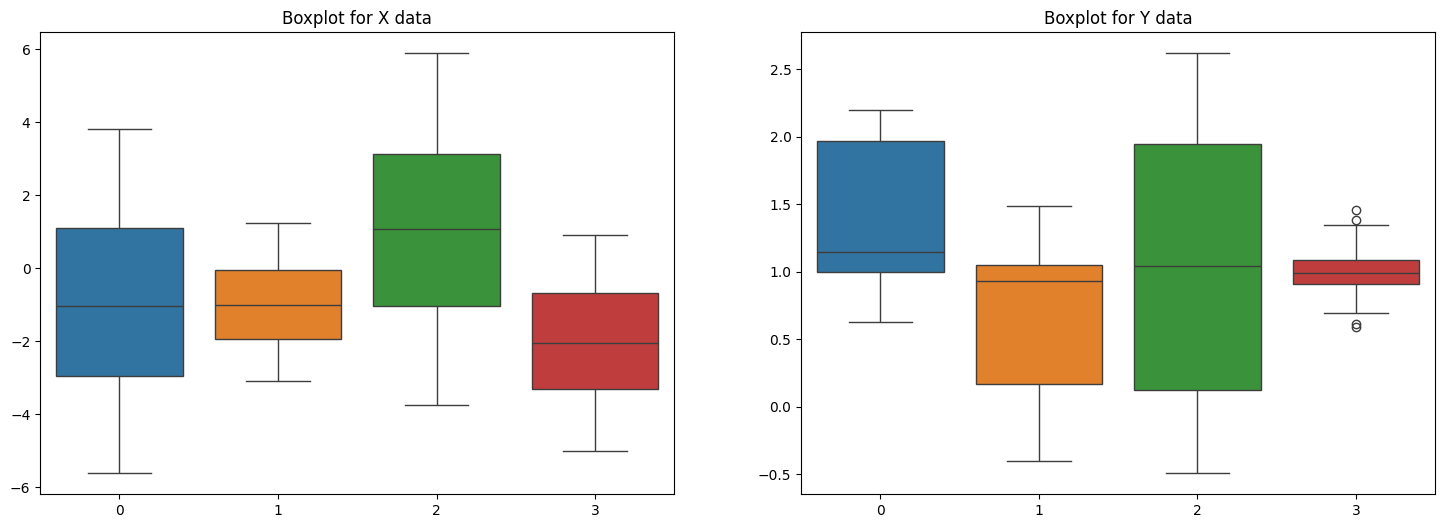

In [347]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(data=df_x, ax=axs[0])
axs[0].set_title('Boxplot for X data')

sns.boxplot(data=df_y, ax=axs[1])
axs[1].set_title('Boxplot for Y data')
pass

**Комментарий**: на первом наборе данных (X) выбросов не наблюдается, в то время как на втором (Y) есть выбросы по четвертому параметру.

### Матрица корреляций

Text(0.5, 1.0, 'Correlation Heatmap for Y data')

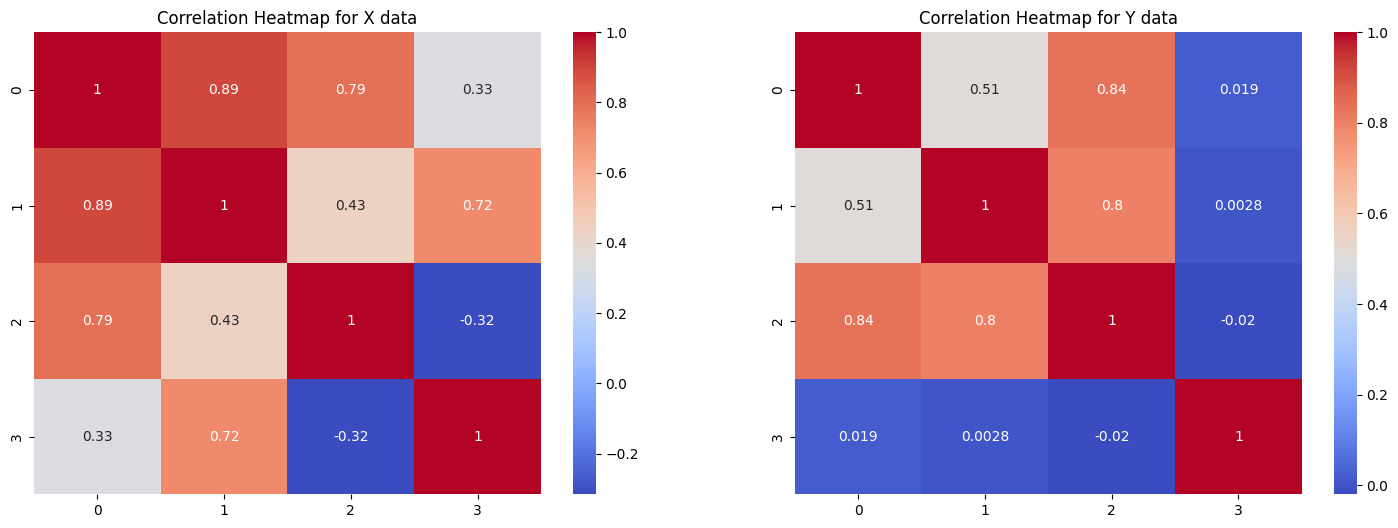

In [348]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

corr_x = df_x.corr(method='pearson')
sns.heatmap(corr_x, annot=True, ax=axs[0], cmap='coolwarm', cbar=True)
axs[0].set_title('Correlation Heatmap for X data')

corr_y = df_y.corr(method='pearson')
sns.heatmap(corr_y, annot=True, ax=axs[1], cmap='coolwarm', cbar=True)
axs[1].set_title('Correlation Heatmap for Y data')

**Комментарий**: матрица корреляций показывает, что некоторые признаки имеют значительную взаимосвязь. Это позволяет предположить, что можно выделить основные компоненты из данных с помощью метода главных компонент (PCA).

### Визуализация предполагаемых кластеров для X и Y

Начнем проверку с 3х компонент (3х-мерного пространства).

In [349]:
def calculate_pca(dataset, n_comp):
  pca = PCA(n_components=n_comp)
  pca.fit(dataset)
  res_pca = np.array(pca.transform(dataset))

  return res_pca

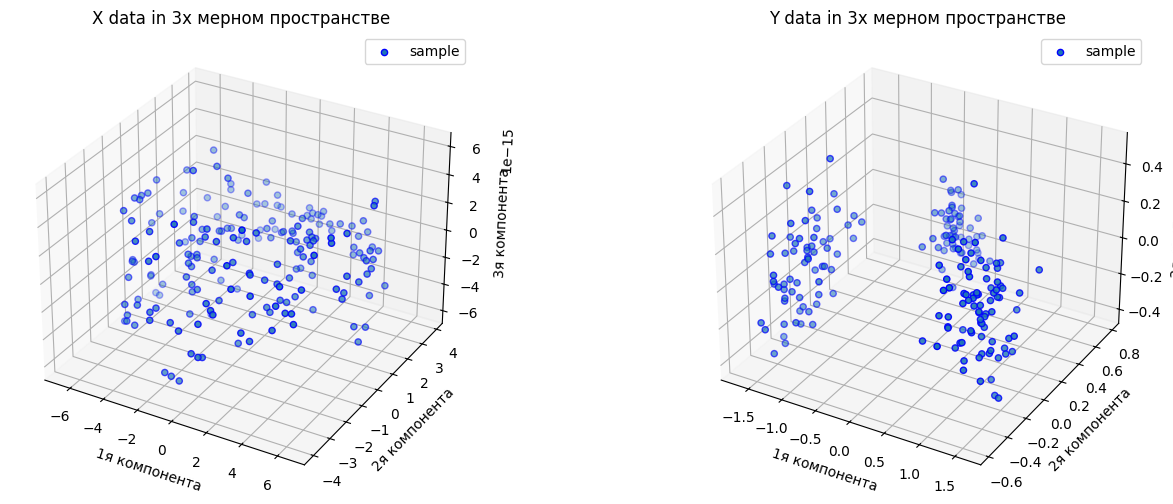

In [350]:
n_comp = 3
fig = plt.figure(figsize=(16, 6))
dataframes = [df_x, df_y]
names = ['X', 'Y']

for i in range(2):
  ax = fig.add_subplot(1, 2, i + 1, projection='3d')
  res_pca = calculate_pca(dataframes[i], n_comp)
  ax.scatter(res_pca[:, 0], res_pca[:, 1], res_pca[:, 2], label='sample', edgecolors='blue')
  plt.legend()
  ax.set_xlabel('1я компонента')
  ax.set_ylabel('2я компонента')
  ax.set_zlabel('3я компонента')
  plt.title(f'{names[i]} data in {n_comp}х мерном пространстве')

**Комментарий**: на основе графиков для Y данных, веротяно, можно выделить 2 кластера, однако для X данных на 3х компонентах нет понимания, поэтому проверим на 2х.

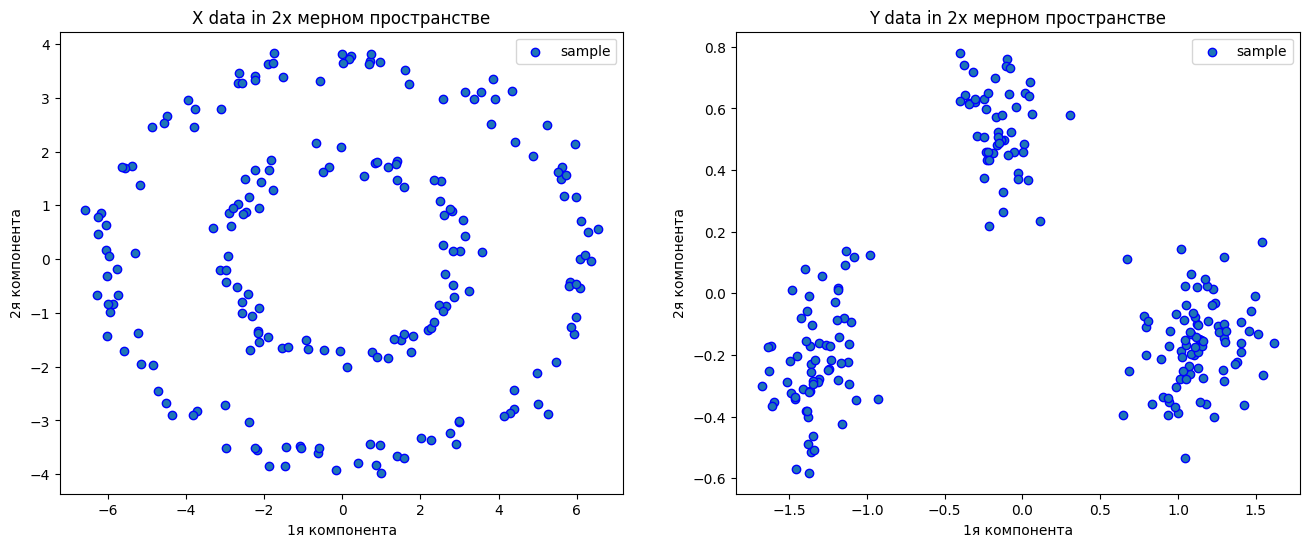

In [351]:
n_comp = 2
fig = plt.figure(figsize=(16, 6))
dataframes = [df_x, df_y]
names = ['X', 'Y']

for i in range(2):
  ax = fig.add_subplot(1, 2, i + 1)
  res_pca = calculate_pca(dataframes[i], n_comp)
  ax.scatter(res_pca[:, 0], res_pca[:, 1], label='sample', edgecolors='blue')
  plt.legend()
  ax.set_xlabel('1я компонента')
  ax.set_ylabel('2я компонента')
  plt.title(f'{names[i]} data in {n_comp}х мерном пространстве')

**Комментарий**: по графикам легко заметить, что явно выделяются 2 кластера для X (внешняя и внутренняя окружности) и 3 группы на наборе Y.

### Расчет расстояний

В исследовании рассмотрим 3 способа вычисления расстояний: Евклидово, Чебышева, Минковского и косинусное.

Для вычисления расстояний были использованы следующие формулы:
- Евклидово расстояние: $euclidean = \sqrt{\sum_{i=1}^n(v_i - u_i)^2}$
- Расстояние Чебышева: $chebyshev = max_i{|v_i - u_i|}$

- Косинусное расстояние: $cosine = 1 - \frac{u \cdot v}{||u||_2 \cdot ||v||_2}$

- Манхэттенское расстояние: $cityblock = \sum_{i=1}^n |v_i - u_i|$

In [352]:
def chebyshev_distances(data: pd.DataFrame) -> pd.DataFrame:
    distances = squareform(pdist(data, metric='chebyshev'))
    return pd.DataFrame(distances)

def euclidean_distances(data: pd.DataFrame) -> pd.DataFrame:
    distances = squareform(pdist(data, metric='euclidean'))
    return pd.DataFrame(distances)

def cosine_distances(data: pd.DataFrame) -> pd.DataFrame:
    distances = squareform(pdist(data, metric='cosine'))
    return pd.DataFrame(distances)

def cityblock_distances(data: pd.DataFrame) -> pd.DataFrame:
    distances = squareform(pdist(data, metric='cityblock'))
    return pd.DataFrame(distances)

In [353]:
chebyshev_x = chebyshev_distances(df_x)
euclidean_x = euclidean_distances(df_x)
cosine_x = cosine_distances(df_x)
cityblock_x = cityblock_distances(df_x)

chebyshev_y = chebyshev_distances(df_y)
euclidean_y = euclidean_distances(df_y)
cosine_y = cosine_distances(df_y)
cityblock_y = cityblock_distances(df_y)


###Переход к матрице близостей:

Ядро Гаусса _(Gaussian kernel)_ для пары элементов _(i, j)_  в матрице расстояний по формуле: $kernel_{ij} = \exp \left( -\frac{{\text{distance}_{ij}^2}}{{2 \cdot \sigma^2}} \right)$

In [354]:
def convert_distance_to_similarity(distance_matrix: pd.DataFrame, sigma:float) -> pd.DataFrame:
    return pd.DataFrame(np.exp(-(distance_matrix.values.astype(float))**2/(2*sigma**2)))

In [355]:
similarity_euclidean_x = convert_distance_to_similarity(euclidean_x, 0.45)
similarity_chebyshev_x = convert_distance_to_similarity(chebyshev_x, 0.3)
similarity_cosine_x = convert_distance_to_similarity(cosine_x, 0.45)
similarity_cityblock_x = convert_distance_to_similarity(cityblock_x, 0.45)

similarity_euclidean_y = convert_distance_to_similarity(euclidean_y, 0.45)
similarity_chebyshev_y = convert_distance_to_similarity(chebyshev_y, 0.3)
similarity_cosine_y = convert_distance_to_similarity(cosine_y, 0.45)
similarity_cityblock_y = convert_distance_to_similarity(cityblock_y, 0.45)

In [356]:
def similarity_matrix_to_graph(similarity_matrix, threshold=0):
    G = nx.Graph()
    num_nodes = len(similarity_matrix)

    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if similarity_matrix[i][j] > threshold:
                G.add_edge(i, j, weight=similarity_matrix[i][j])

    return G


def plot_graph(sim_x, sim_y, threshold_x, threshold_y):

  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  graph1 = similarity_matrix_to_graph(sim_x, threshold=threshold_x)
  graph2 = similarity_matrix_to_graph(sim_y, threshold=threshold_y)

  ax = fig.add_subplot(1, 2, 1)
  pos1 = nx.spring_layout(graph1)
  nx.draw(graph1, pos1, ax=ax, with_labels=False)

  ax = fig.add_subplot(1, 2, 2)
  pos2 = nx.spring_layout(graph2)
  nx.draw(graph2, pos2, ax=ax, with_labels=False)

  plt.show()

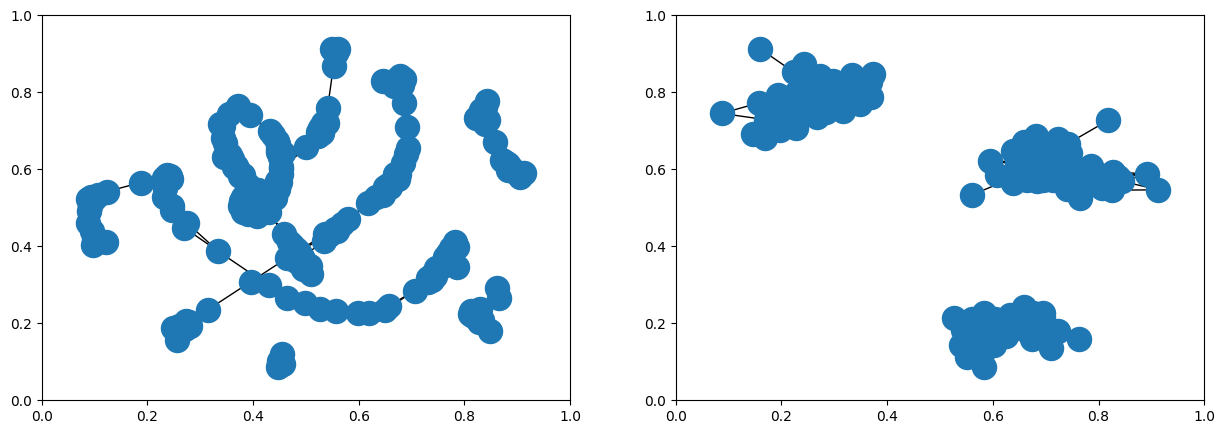

In [357]:
plot_graph(similarity_euclidean_x, similarity_euclidean_y, threshold_x=0.2, threshold_y=0.8)

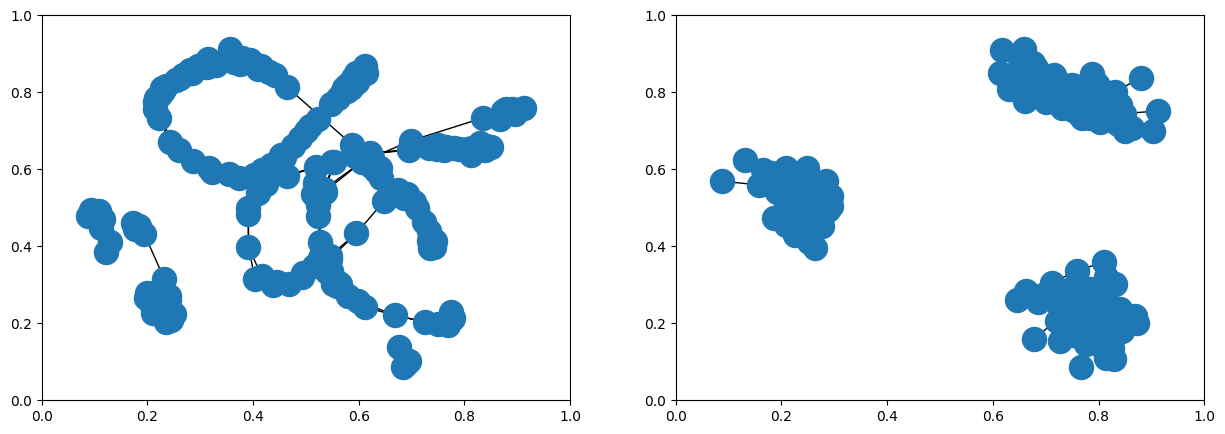

In [358]:
plot_graph(similarity_chebyshev_x, similarity_chebyshev_y, threshold_x=0.1, threshold_y=0.8)

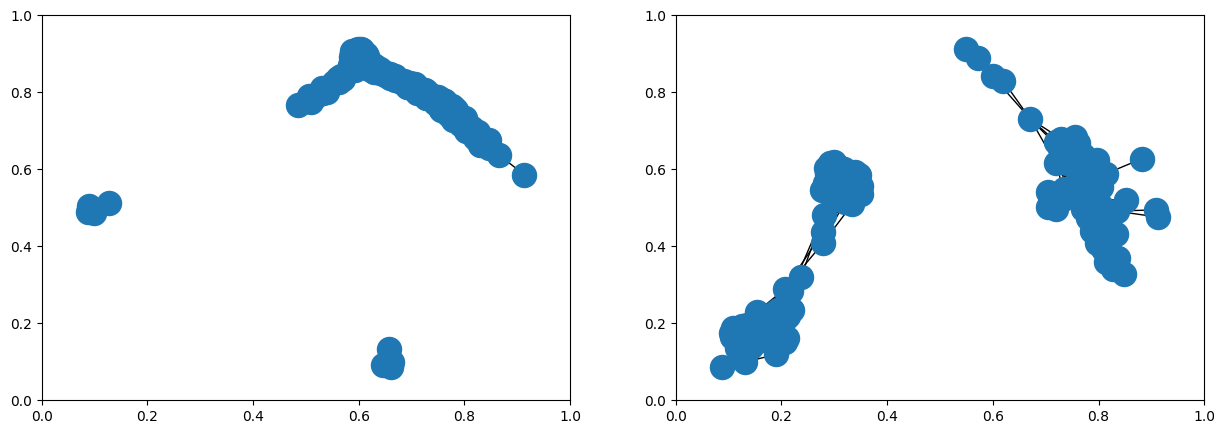

In [359]:
plot_graph(similarity_cosine_x, similarity_cosine_y, threshold_x=0.99, threshold_y=0.9998)

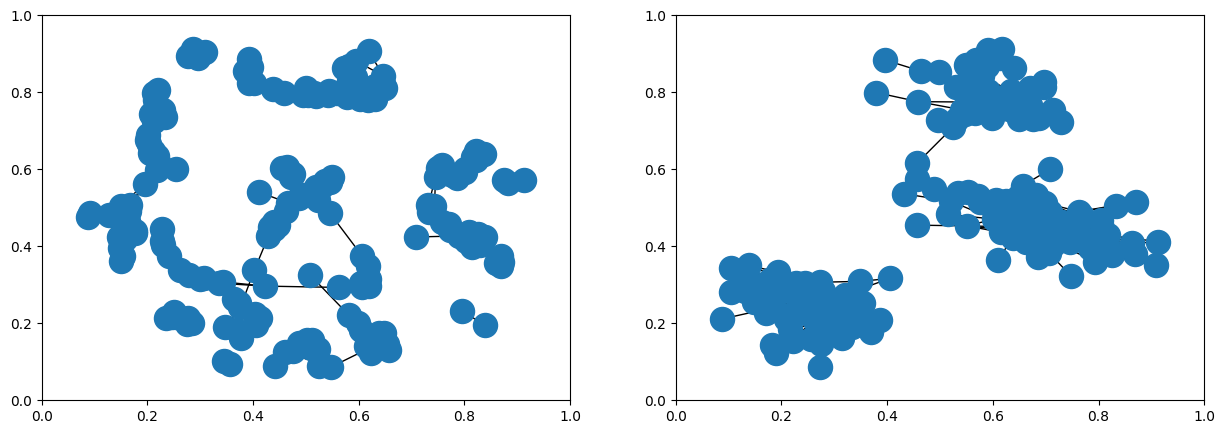

In [360]:
plot_graph(similarity_cityblock_x, similarity_cityblock_y, threshold_x=0.05, threshold_y=0.7)

**Комментарий**: При построении графовой модели рассматривалось четыре вида расстояний. Для Евклидова, Чебышева и Манхэттенского растояний графики имеют сходий вид (разбиение). Данные также были поделены на 2 кластера для набора данных X, и на 3 для набора данных Y. Однако косинусовое растояние отличается.



# Кластеризация для числа кластеров k=2

### 1.1 Найти разбиение каждого набора данных на 2 кластера с помощью следующих алгоритмов
- Один (на выбор) из алгоритмов иерархической кластеризации: Threshold method=MST method=Single Linkage, Complete Linkage, Average Linkage, Centroid Linkage, Ward Linkage (для выбранного алгоритма использовать его вариант, адаптированный для similarity вместо distance).
- k-means (использовать матрицу расстояний)
- EM алгоритм (использовать матрицу расстояний)
- Spectral algorithm (один из вариантов Normalized или Unnormalized, использовать матрицу близостей)

In [361]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage as hier_linkage

In [362]:
def calculate_mode_fit_predict(model, data):
  if  data.shape[0] != data.shape[1]:
    data = np.array(data)
  return model.fit_predict(data)


def show_scatters_and_dendograms(model, model_name, data, name, type, Z_method = None):
  clusters = calculate_mode_fit_predict(model, data)
  Z = hier_linkage(data, method=Z_method)
  cluster = pd.DataFrame()
  cluster['Cluster'] = clusters
  pca = PCA(n_components=2)

  if type == 'X':
    reduced_data = pca.fit_transform(df_x.iloc[:, :-1])
  elif type == 'Y':
    reduced_data = pca.fit_transform(df_y.iloc[:, :-1])

  fig = plt.figure(figsize=(16, 3))

  ax = fig.add_subplot(1, 2, 1)
  dendrogram(Z, ax=ax)
  ax.set_title(f'Dendrogram {name}  by {model_name} for {type}')

  ax = fig.add_subplot(1, 2, 2)
  ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster['Cluster'], cmap='viridis', s=100)
  ax.set_title(f'Scatter Plot by {model_name} for {type}')

  # plt.title(f'Dendrogram {name} by {model_name} for {type}')
  plt.show()


def show_scatters(model, model_name, data, name, type):
  if len(data.shape) == 2 and data.shape[0] == data.shape[1]:
    clusters = calculate_mode_fit_predict(model, data)
  else:
    clusters = calculate_mode_fit_predict(model, euclidean_distances(data))
  cluster = pd.DataFrame()
  cluster['Cluster'] = clusters
  pca = PCA(n_components=2)

  if type == 'X':
    reduced_data = pca.fit_transform(df_x.iloc[:, :-1])
  elif type == 'Y':
    reduced_data = pca.fit_transform(df_y.iloc[:, :-1])

  fig = plt.figure(figsize=(8, 3))

  ax = fig.add_subplot(1, 1, 1)
  ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster['Cluster'], cmap='viridis', s=100)
  ax.set_title(f'Scatter Plot {0}')

  plt.title(f'Dendrogram {name} by {model_name} for {type}')
  plt.show()

### Models

In [363]:
n_clusters = 2

distances_names = ['Euclidean', 'Chebyshev', 'Cosine', 'Cityblock']

dist_x = [euclidean_x, chebyshev_x, cosine_x, cityblock_x]
dist_y = [euclidean_y, chebyshev_y, cosine_y, cityblock_y]

models_and_data = [
    {'model' : AgglomerativeClustering(n_clusters=n_clusters, linkage='single'), 'data_x' : dist_x, 'data_y' : dist_y, 'model_type' : 'hierarchical', 'model_name' : 'Single Linkage'},
    {'model' : KMeans(n_clusters=n_clusters, n_init='auto', max_iter=300), 'data_x' : [df_x], 'data_y' : [df_y], 'model_type' : 'others', 'model_name' : 'KMeans'},
    {'model' : GaussianMixture(n_components=n_clusters, covariance_type='full', max_iter=300, init_params="random_from_data", random_state=42), 'data_x' : [df_x], 'data_y' : [df_y], 'model_type' : 'others', 'model_name' : 'EM algorithm'},
    {'model' : SpectralClustering(n_clusters=n_clusters, assign_labels='cluster_qr', affinity='precomputed'), 'data_x' : dist_x, 'data_y' : dist_y, 'model_type' : 'others', 'model_name' : 'Spectral algorithm'}
 ]

Single Linkage


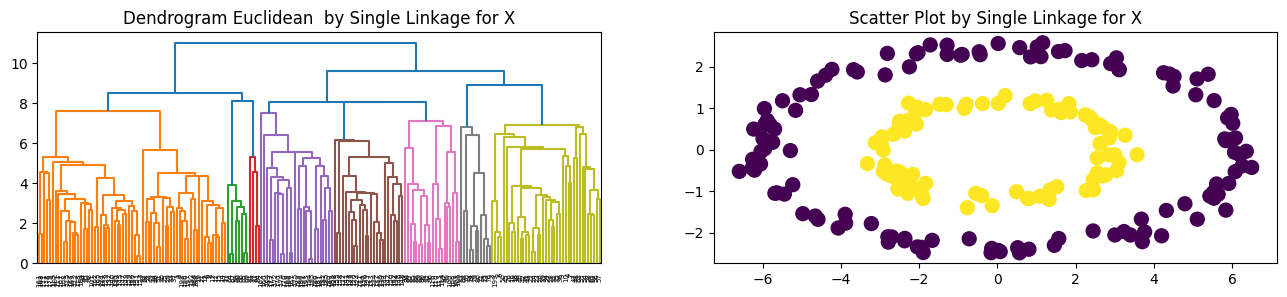

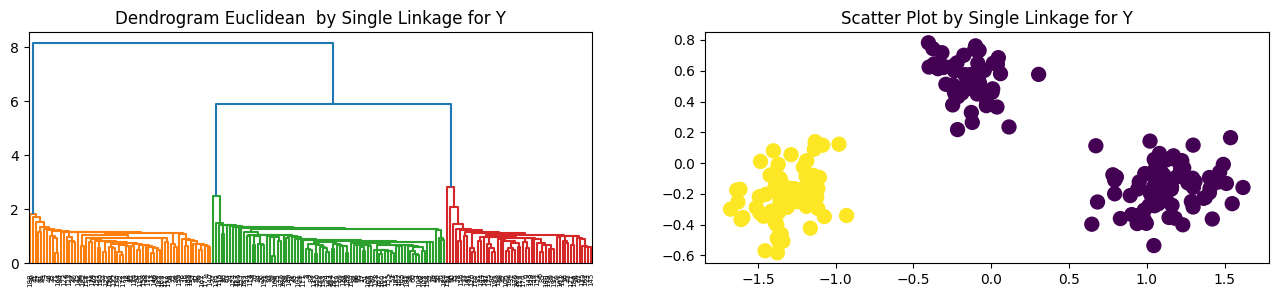


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



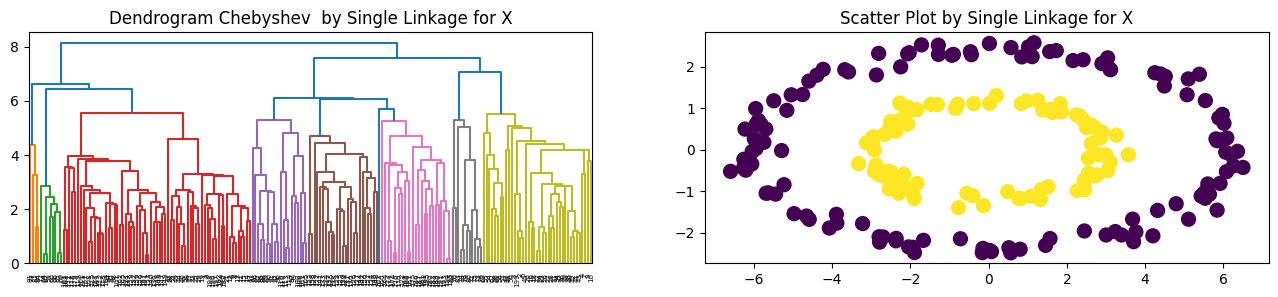

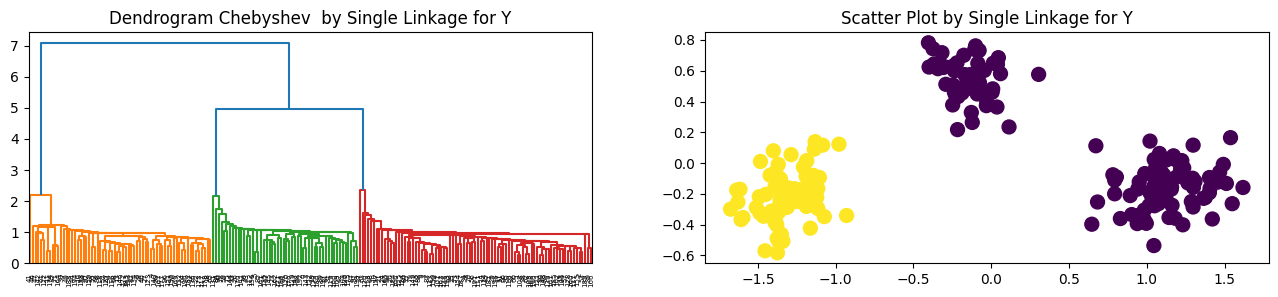


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



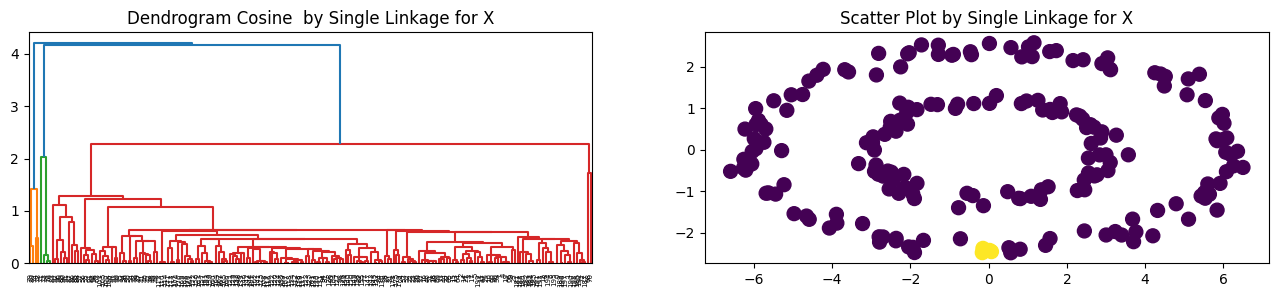

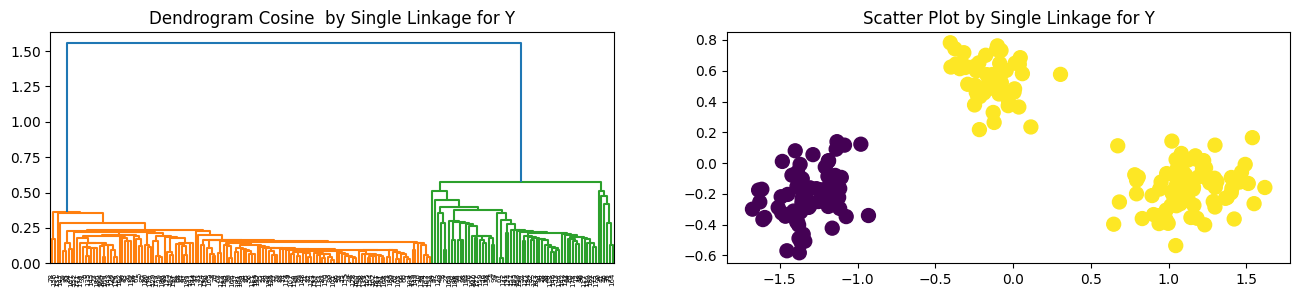


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



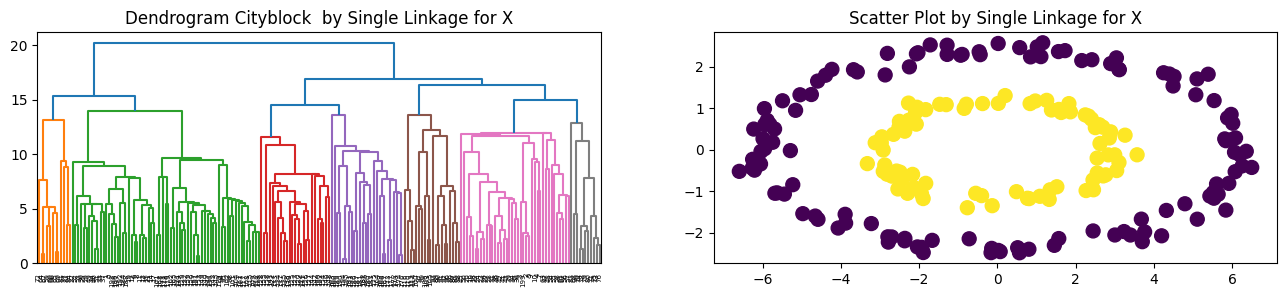

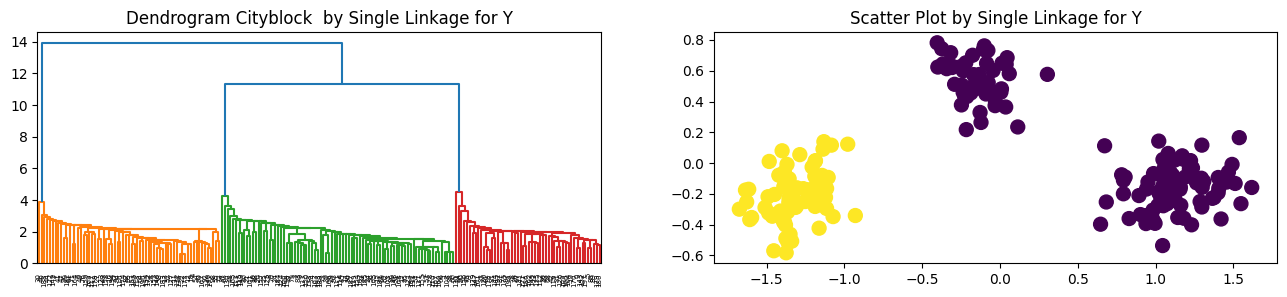


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 

KMeans


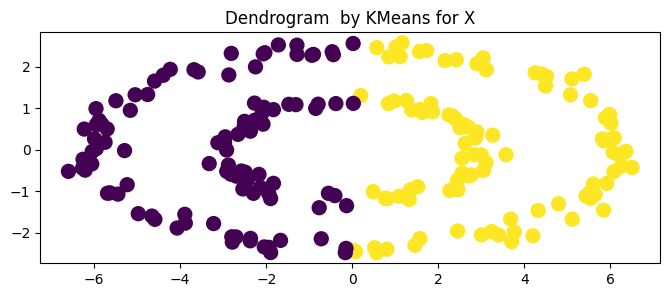

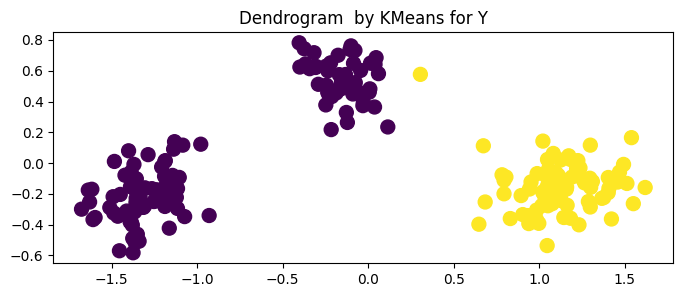


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 

EM algorithm


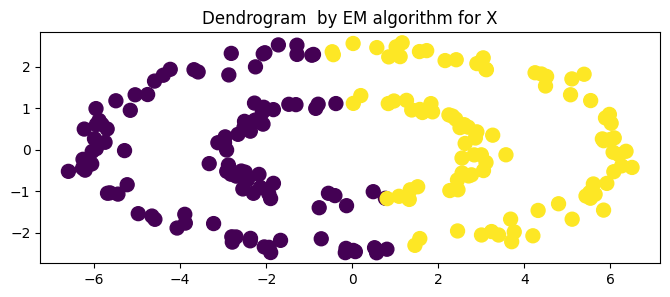

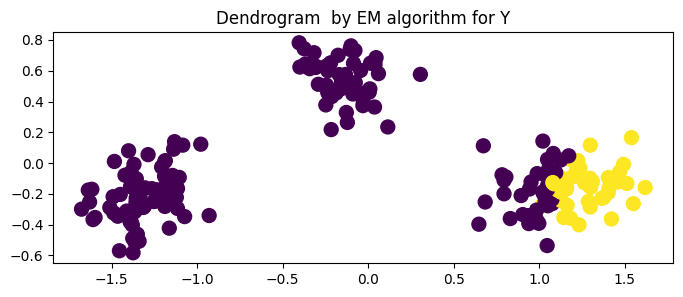


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 

Spectral algorithm


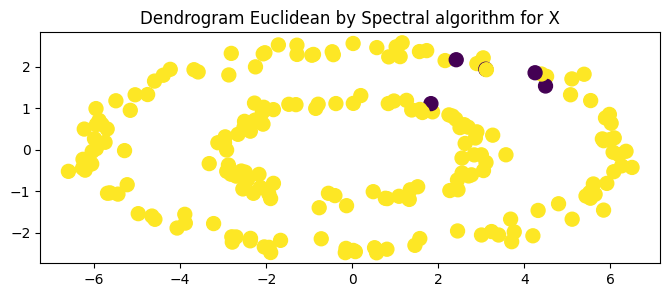

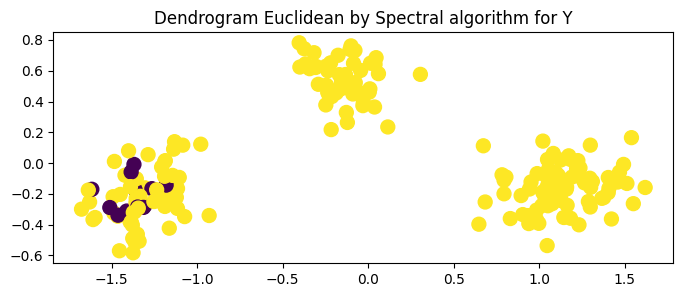


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



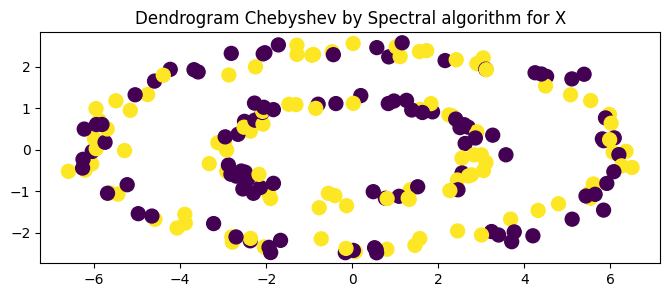

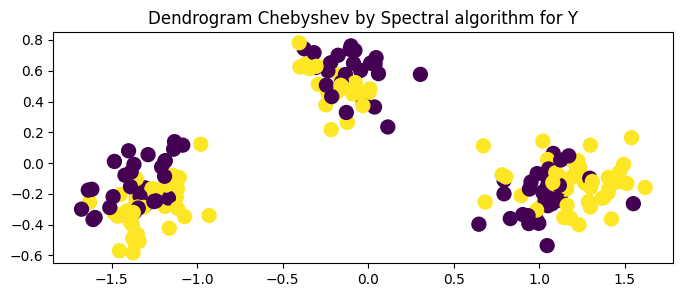


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



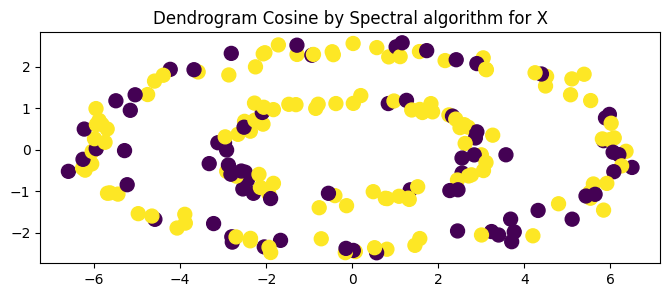

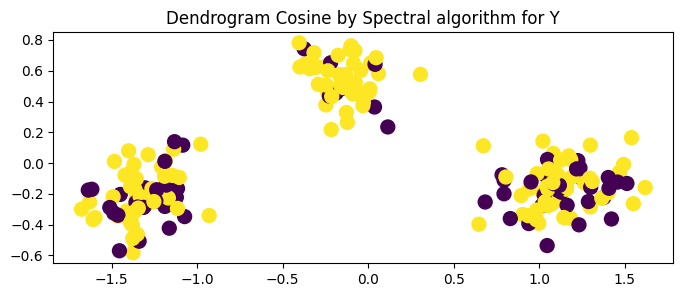


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



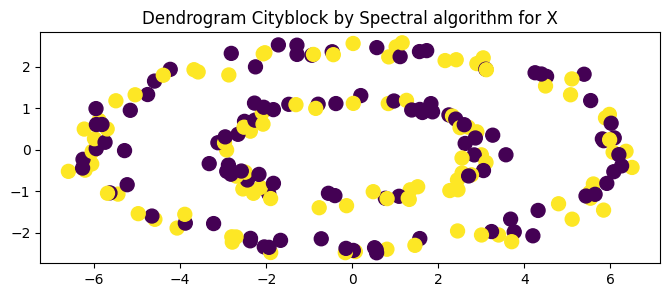

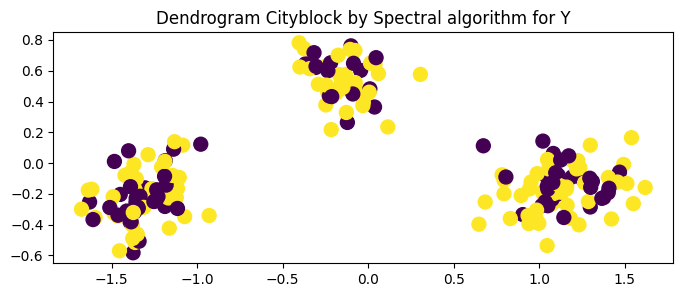


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



In [364]:
for i in range(len(models_and_data)):
  model = models_and_data[i]['model']
  model_name = models_and_data[i]['model_name']
  data_x = models_and_data[i]['data_x']
  data_y = models_and_data[i]['data_y']

  print(model_name)

  for j in range(len(data_x)):
    if len(data_x) == 1:
      dist_name = ''
    else:
      dist_name = distances_names[j]

    if models_and_data[i]['model_type'] == 'hierarchical':
      show_scatters_and_dendograms(model, model_name, data_x[j], dist_name, type='X', Z_method='single')
      show_scatters_and_dendograms(model, model_name, data_y[j], dist_name, type='Y', Z_method='single')

    elif models_and_data[i]['model_type'] == 'others':
      show_scatters(model, model_name, data_x[j], dist_name, type='X')
      show_scatters(model, model_name, data_y[j], dist_name, type='Y')

    if i != len(models_and_data):
      print('\n', '-' * 200, '\n')

**Комментарий**: Иерархическая кластеризация (single linkage) для трех рассматриваемых расстояний схожая. Были выделенны 2 кластера, образующие внутреннее и внешнее кольцо для данных X. Результат на основе косинусового расстояния для X неудовлетворителен. По Y разбиение одинаковое,  при делении на два кластера данных, в которых предполагаемое количество кластеров 3, некоторые объединились между собой.

Графики полученные для K-Means и EM похожи для случая X. Данные будто рассечены прямой, где второй кластер над прямой, а второй - под ней. Для Y K-Means результат схожий с иерархическим.

Выделение кластеров судя по графикам не являются репрезентативным для Spectral algorithm. Кластеры смешаны между собой.

# 1.2 Сравнить попарно разбиения, полученные разными методами с помощью RAND индекса (вычислить RAND индекс для каждой пары разбиений). Дать комментарий к результату.

Повышение индекса RAND определялось следующим образом:
\begin{equation}\Large R = \frac{(a + b)}{(a+b+c+d)}\end{equation}

- a - кол-во пар элементов в N, находящиеся в **одном** и том же подмножестве в C1 и в **одном** и том же подмножестве в C2;
- b - кол-во пар элементов в N, находящиеся в **разных** подмножествах в C1 и в **разных** подмножествах в C2;
- c - кол-во пар элементов в N, находящиеся в **одном** и том же подмножестве в C1 и в **разных** подмножествах в C2;
- d - кол-во пар элементов в N, находящиеся в **разных** подмножествах в C1 и в **одном** и том же подмножестве в C2.

In [365]:
def process_dict(models_and_data, type_of_data : str):
  results = {}
  for i in range(len(models_and_data)):
    model = models_and_data[i]['model']
    model_name = models_and_data[i]['model_name']
    data = models_and_data[i][type_of_data]
    for j in range(len(data)):
      if len(data) == 1:
        dist_name = ''
      else:
        dist_name = distances_names[j]
      res = calculate_mode_fit_predict(model, data[j])
      results[f"{model_name}_{dist_name}"] = res

  return results

In [366]:
def calculate_rand_index(clasterisations, type_of_data, rand_function=rand_score):
  processed_clasterizartions = process_dict(models_and_data, type_of_data)

  statistic = pd.DataFrame(columns=processed_clasterizartions.keys(), index=processed_clasterizartions.keys())

  for key1 in processed_clasterizartions.keys():
    for key2 in processed_clasterizartions.keys():
        statistic[key1][key2] = rand_function(processed_clasterizartions[key1], processed_clasterizartions[key2])

  return statistic

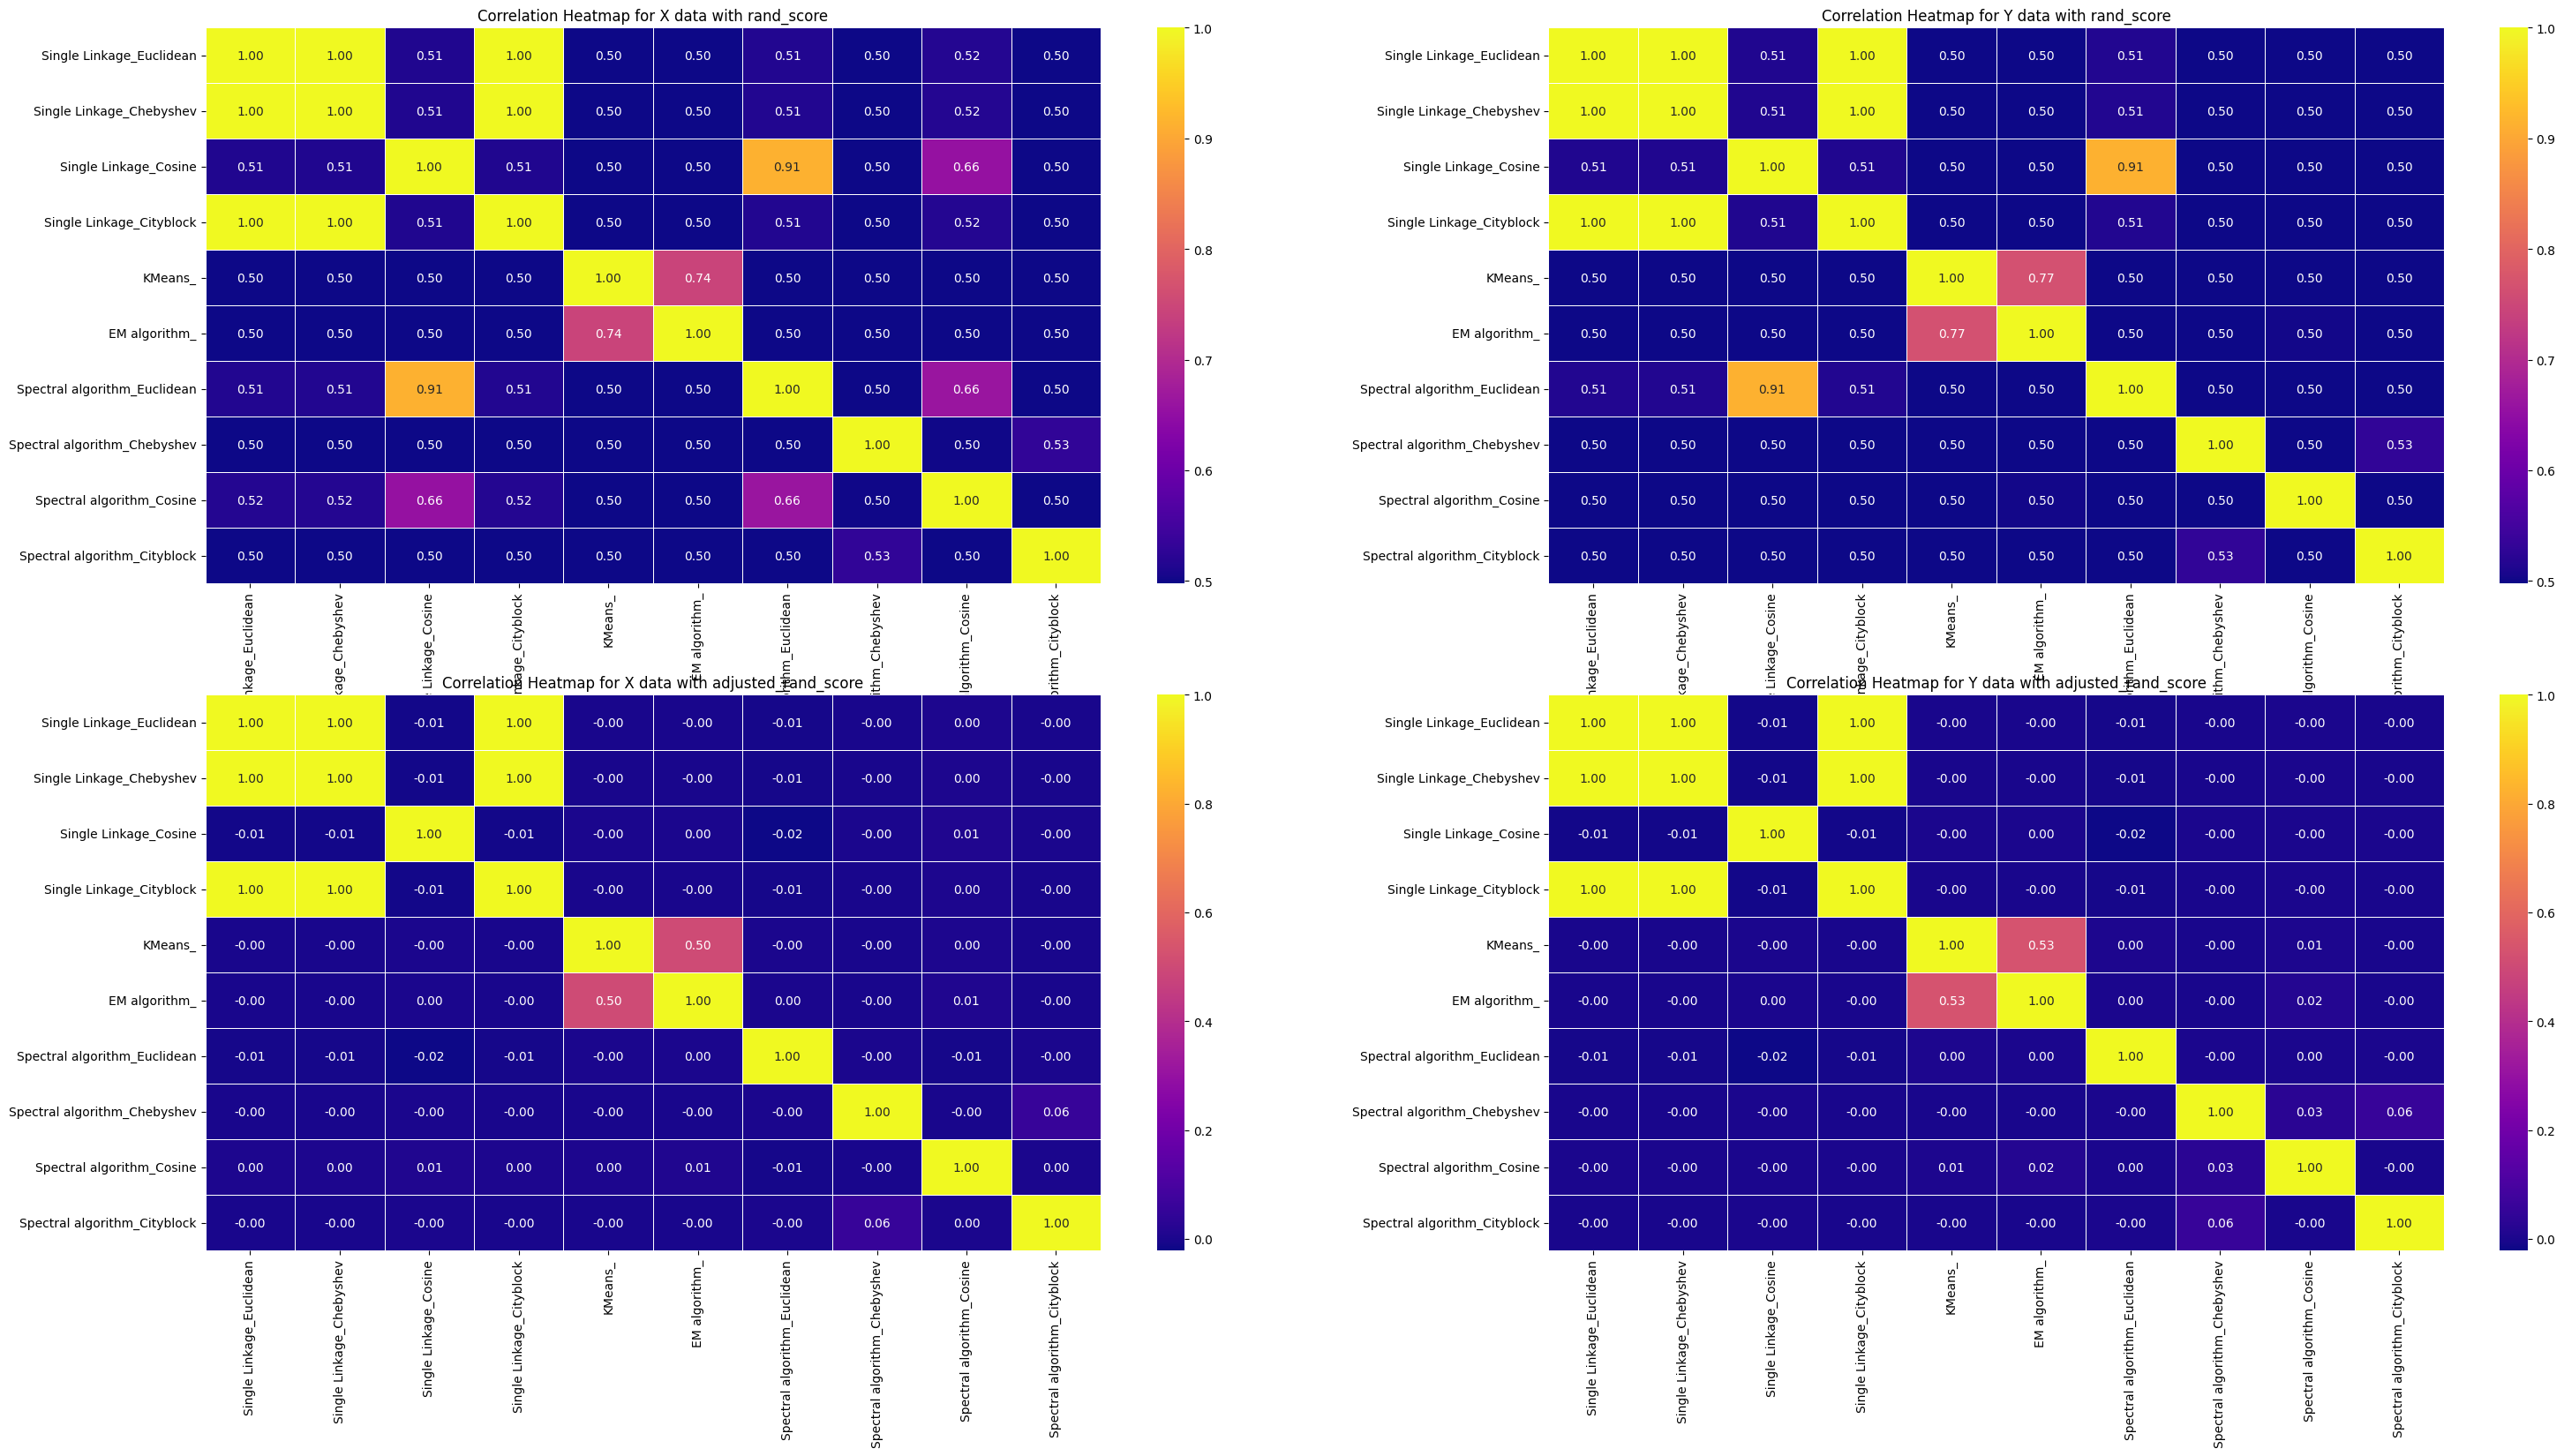

In [367]:
fig, axs = plt.subplots(2, 2, figsize=(36, 18))

statistic_x = calculate_rand_index(models_and_data, type_of_data='data_x')
statistic_x = statistic_x.apply(pd.to_numeric, errors='coerce')
sns.heatmap(statistic_x, cmap='plasma', ax=axs[0, 0], annot=True, fmt=".2f", linewidths=.5)
axs[0, 0].set_title('Correlation Heatmap for X data with rand_score')

statistic_y = calculate_rand_index(models_and_data, type_of_data='data_x')
statistic_y = statistic_y.apply(pd.to_numeric, errors='coerce')
sns.heatmap(statistic_y, cmap='plasma', ax=axs[0, 1], annot=True, fmt=".2f", linewidths=.5)
axs[0, 1].set_title('Correlation Heatmap for Y data with rand_score')

statistic_x_adg = calculate_rand_index(models_and_data, type_of_data='data_x', rand_function=adjusted_rand_score)
statistic_x_adg = statistic_x_adg.apply(pd.to_numeric, errors='coerce')
sns.heatmap(statistic_x_adg, cmap='plasma', ax=axs[1, 0], annot=True, fmt=".2f", linewidths=.5)
axs[1, 0].set_title('Correlation Heatmap for X data with adjusted_rand_score')

statistic_y_adg = calculate_rand_index(models_and_data, type_of_data='data_x', rand_function=adjusted_rand_score)
statistic_y_adg = statistic_y_adg.apply(pd.to_numeric, errors='coerce')
sns.heatmap(statistic_y_adg, cmap='plasma', ax=axs[1, 1], annot=True, fmt=".2f", linewidths=.5)
axs[1, 1].set_title('Correlation Heatmap for Y data with adjusted_rand_score')
pass

**Комментарий**: Значение **Rand Score** варьируется от 0 до 1, где 1 означает полное совпадение. **Adjusted Rand Score** — это модификация, которая корректирует количество случайных совпадений.

Aлгоритм single linkage дает похожие результаты со всеми расстояниями кроме косинусного (соотвествует Spectral algorithm by Euclidean). K-Means и EM также имеет неплохой парный RAND индекс. Это подтверждается ранее приведенными визуализациями.

### 1.3 Вычислить значение функции модулярности для каждого разбиения на 2 кластера из п.1.1

In [368]:
def get_sets_of_classes(clusterization):
    partition = [set() for _ in range(len(np.unique(clusterization)))]
    for i in range(len(clusterization)):
        partition[clusterization[i]].add(i)
    return partition

def calculate_modularity(singularity_graphs, models_and_data, type_of_data):
    processed_clasterizartions = process_dict(models_and_data, type_of_data)

    for model_clusters in processed_clasterizartions.keys():
        communities = get_sets_of_classes(processed_clasterizartions[model_clusters])
        name_dist = model_clusters.split('_')[1]

        if name_dist not in singularity_graphs.keys():
          graph = singularity_graphs['Euclidean']
        else:
          graph = singularity_graphs[name_dist]
        processed_clasterizartions[model_clusters] = nx.community.modularity(graph, communities)
    return pd.DataFrame(processed_clasterizartions.values(), index=processed_clasterizartions.keys(), columns=['modularity'])

In [369]:
singularity_graphs_x = {'Euclidean': similarity_matrix_to_graph(similarity_euclidean_x),
                        'Chebyshev': similarity_matrix_to_graph(similarity_chebyshev_x),
                        'Cosine': similarity_matrix_to_graph(similarity_cosine_x),
                        'Cityblock': similarity_matrix_to_graph(similarity_cityblock_x)}
calculate_modularity(singularity_graphs_x, models_and_data, 'data_x')

modularity
Single Linkage_Euclidean        0.499082
Single Linkage_Chebyshev        0.499368
Single Linkage_Cosine           0.001261
Single Linkage_Cityblock        0.499110
KMeans_                         0.486859
EM algorithm_                   0.468982
Spectral algorithm_Euclidean    0.003099
Spectral algorithm_Chebyshev   -0.009799
Spectral algorithm_Cosine      -0.000852
Spectral algorithm_Cityblock   -0.059241

In [370]:
singularity_graphs_y = {'Euclidean': similarity_matrix_to_graph(similarity_euclidean_y),
                        'Chebyshev': similarity_matrix_to_graph(similarity_chebyshev_y),
                        'Cosine': similarity_matrix_to_graph(similarity_cosine_y),
                        'Cityblock': similarity_matrix_to_graph(similarity_cityblock_y)}
calculate_modularity(singularity_graphs_y, models_and_data, 'data_y')

modularity
Single Linkage_Euclidean        0.412206
Single Linkage_Chebyshev        0.418647
Single Linkage_Cosine           0.048242
Single Linkage_Cityblock        0.418632
KMeans_                         0.486507
EM algorithm_                   0.412206
Spectral algorithm_Euclidean    0.016466
Spectral algorithm_Chebyshev    0.044093
Spectral algorithm_Cosine      -0.002788
Spectral algorithm_Cityblock   -0.010248

**Комментарий**: сравнивая модулярности на наборах данных при попытки кластеризации данных при k = 2 мы видим, что на данных X самую высокую модулярность показала иерархическая кластеризация (кроме косинусного расстояния) ~ 0.49, на данных Y к ним (0.41) еще добавляется EM (0.41)

### 1.4 Сделать общие выводы по возможности разбиения на 2 кластера каждого набора данных.

**Набор данных X**:
Лучшие результаты показала иерархическая кластаризация (single linkage) с Евклидовым, Манхэттенским, расстоянием Чебышева (выделили в кластеры "кольца"). Остальные дали не очень удовлетворительные результаты и плохо отражают близость точек для этого набора данных.

**Набор данных Y**:
Практически все методы продемонстрировали одинаковую кластеризацию на наборе данных Y.
Спектральный и иерархический на основе косинусного расстояния алгоритмы показывают отличные от других методов кластерное разбиение данных и дают меньшую модулярность (особенно спектральный).

# 2.Кластеризация для числа кластеров k=3.

### 2.1 Найти разбиение каждого набора данных на 3 кластера с помощью следующих алгоритмов
- Один (на выбор) из алгоритмов иерархической кластеризации: Threshold method=MST method=Single Linkage, Complete Linkage, Average Linkage, Centroid Linkage, Ward Linkage (для выбранного алгоритма использовать его вариант, адаптированный для similarity вместо distance).
- k-means (использовать матрицу расстояний)
- EM алгоритм (использовать матрицу расстояний)
- Spectral algorithm (один из вариантов Normalized или Unnormalized, использовать матрицу близостей)

In [371]:
n_clusters = 3

distances_names = ['Euclidean', 'Chebyshev', 'Cosine', 'Cityblock']

dist_x = [euclidean_x, chebyshev_x, cosine_x, cityblock_x]
dist_y = [euclidean_y, chebyshev_y, cosine_y, cityblock_y]

models_and_data = [
    {'model' : AgglomerativeClustering(n_clusters=n_clusters, linkage='single'), 'data_x' : dist_x, 'data_y' : dist_y, 'model_type' : 'hierarchical', 'model_name' : 'Single Linkage'},
    {'model' : KMeans(n_clusters=n_clusters, n_init='auto', max_iter=300), 'data_x' : [df_x], 'data_y' : [df_y], 'model_type' : 'others', 'model_name' : 'KMeans'},
    {'model' : GaussianMixture(n_components=n_clusters, covariance_type='full', max_iter=300, init_params="random_from_data", random_state=42), 'data_x' : [df_x], 'data_y' : [df_y], 'model_type' : 'others', 'model_name' : 'EM algorithm'},
    {'model' : SpectralClustering(n_clusters=n_clusters, assign_labels='cluster_qr', affinity='precomputed'), 'data_x' : dist_x, 'data_y' : dist_y, 'model_type' : 'others', 'model_name' : 'Spectral algorithm'}
 ]

Single Linkage


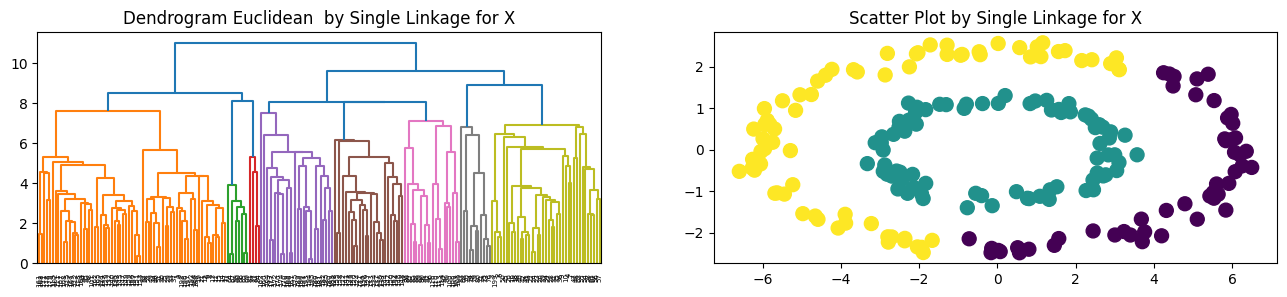

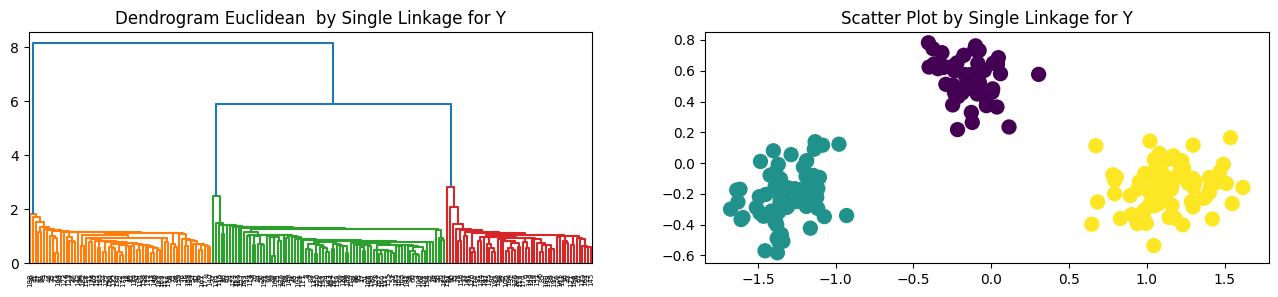


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



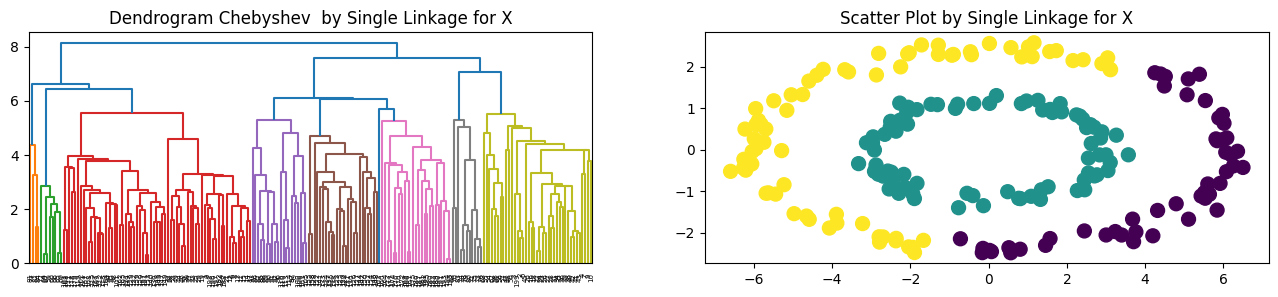

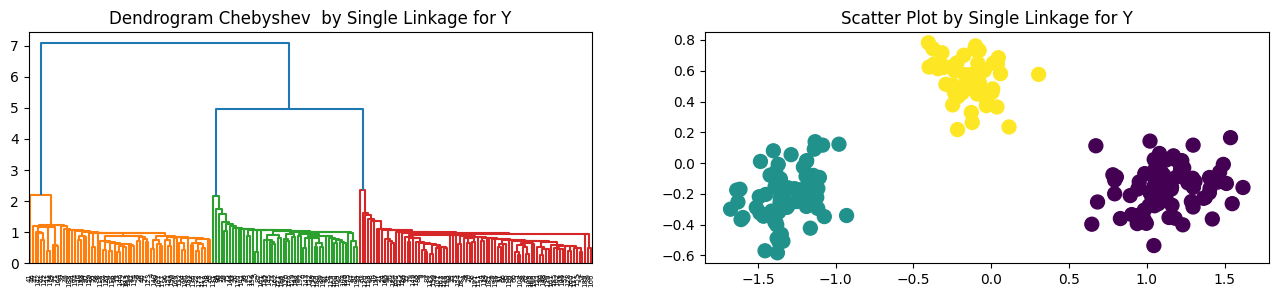


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



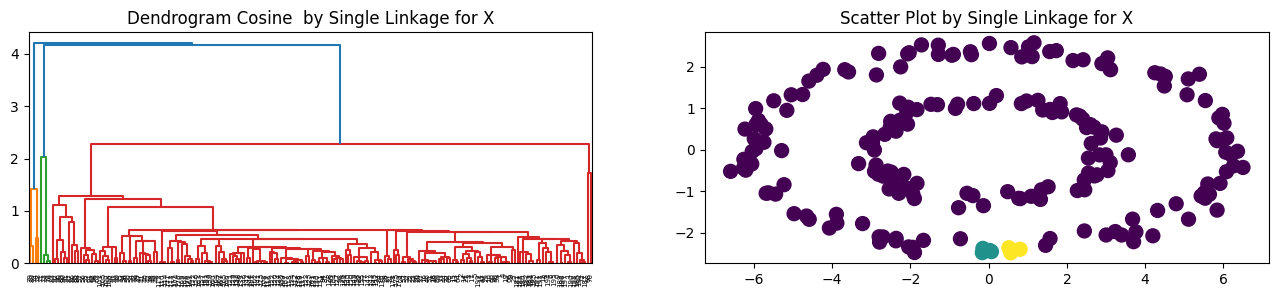

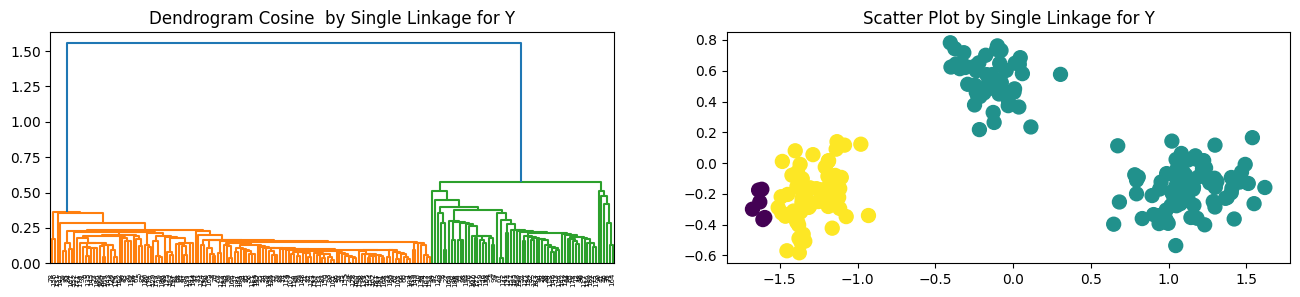


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



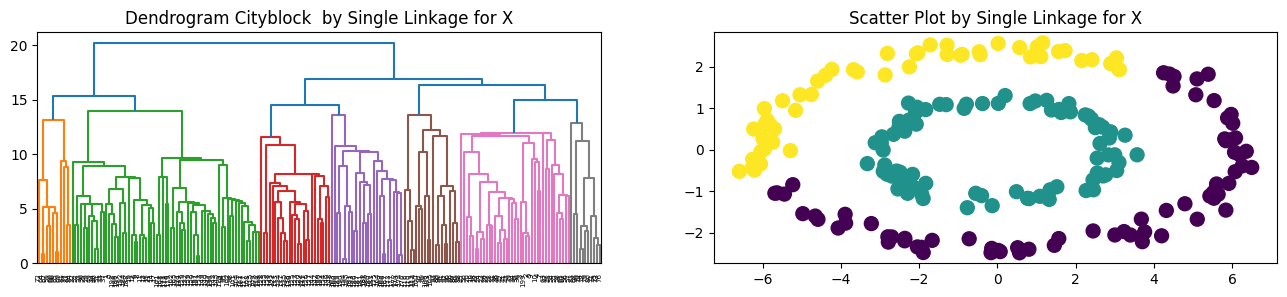

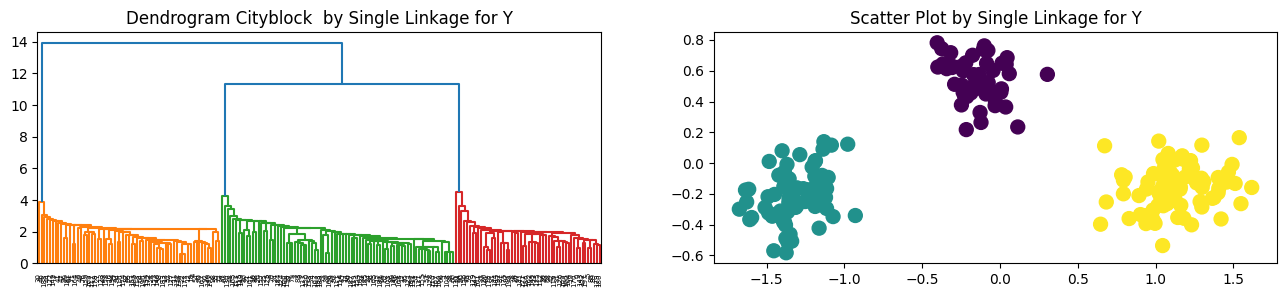


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 

KMeans


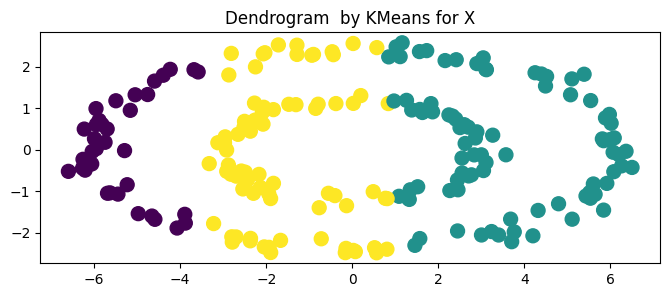

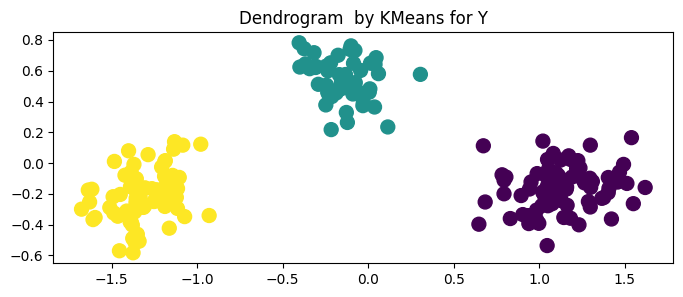


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 

EM algorithm


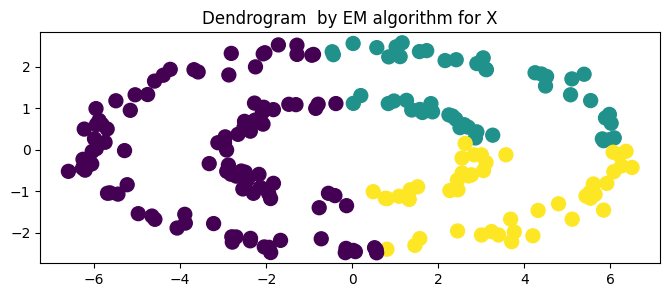

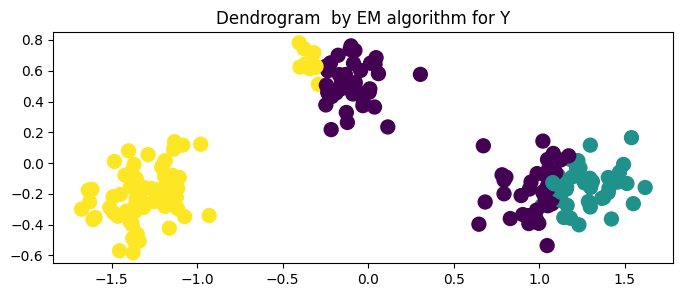


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 

Spectral algorithm


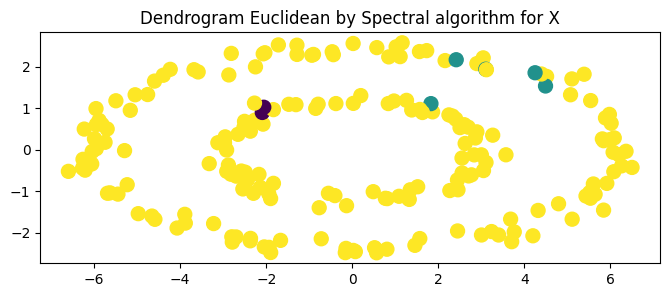

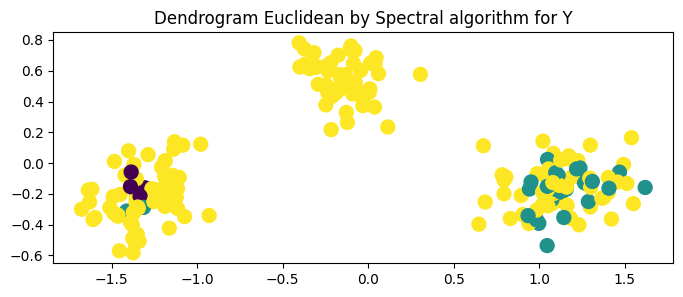


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



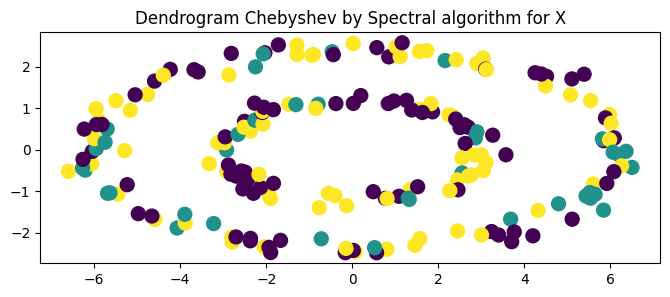

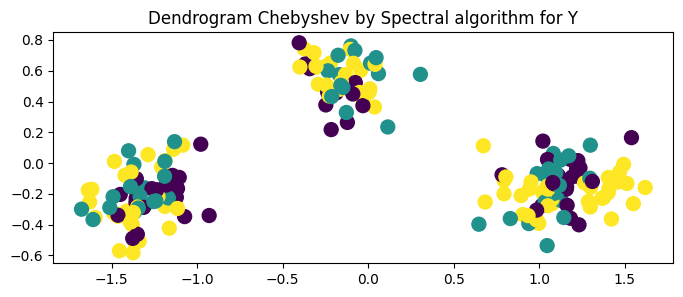


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



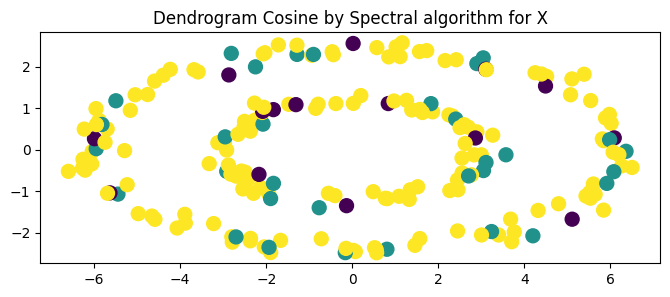

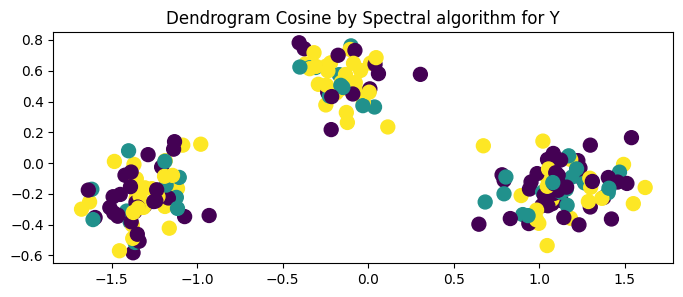


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



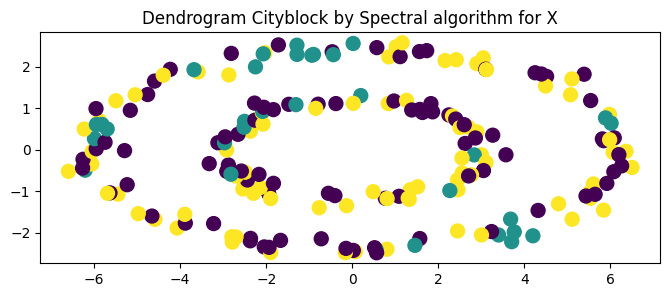

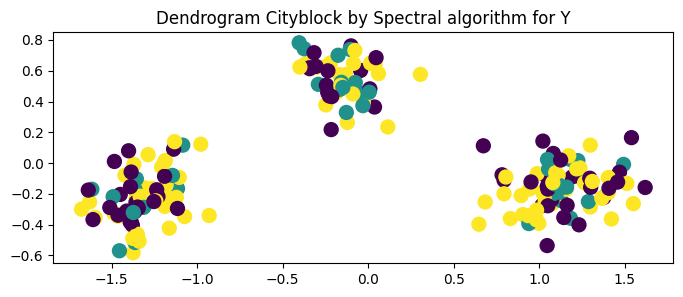


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



In [372]:
for i in range(len(models_and_data)):
  model = models_and_data[i]['model']
  model_name = models_and_data[i]['model_name']
  data_x = models_and_data[i]['data_x']
  data_y = models_and_data[i]['data_y']

  print(model_name)

  for j in range(len(data_x)):
    if len(data_x) == 1:
      dist_name = ''
    else:
      dist_name = distances_names[j]

    if models_and_data[i]['model_type'] == 'hierarchical':
      show_scatters_and_dendograms(model, model_name, data_x[j], dist_name, type='X', Z_method='single')
      show_scatters_and_dendograms(model, model_name, data_y[j], dist_name, type='Y', Z_method='single')

    elif models_and_data[i]['model_type'] == 'others':
      show_scatters(model, model_name, data_x[j], dist_name, type='X')
      show_scatters(model, model_name, data_y[j], dist_name, type='Y')

    if i != len(models_and_data):
      print('\n', '-' * 200, '\n')

**Комментарий**: Иерархическая кластеризация (single linkage) для трех рассматриваемых расстояний схожая. При попытке разбиения на 3 кластера датасета X "внешний круг" разбивается на 2 кластера. Результат на основе косинусового расстояния для X неудовлетворителен, как и для Y. Для остальных разбиение одинаковое, количество кластеров 3. кластеры выделены четко, без смешений. Такой же хороший результат и для KMeans.

EM и KMeans как и при кластеризации данных при k = 2 показывают схожие результаты для X. Однако для первого линии разбиения почти перпендикулярны, а для второго параллельны.

Выделение кластеров судя по графикам не являются репрезентативным для Spectral algorithm. Кластеры смешаны между собой, как и при k = 2




### 2.2 Сравнить попарно разбиения, полученные разными методами с помощью RAND индекса (вычислить RAND индекс для каждой пары разбиений). Дать комментарий к результату.

In [373]:
def process_dict(models_and_data, type_of_data : str):
  results = {}
  for i in range(len(models_and_data)):
    model = models_and_data[i]['model']
    model_name = models_and_data[i]['model_name']
    data = models_and_data[i][type_of_data]
    for j in range(len(data)):
      if len(data) == 1:
        dist_name = ''
      else:
        dist_name = distances_names[j]
      res = calculate_mode_fit_predict(model, data[j])
      results[f"{model_name}_{dist_name}"] = res

  return results

In [374]:
def calculate_rand_index(clasterisations, type_of_data, rand_function=rand_score):
  processed_clasterizartions = process_dict(models_and_data, type_of_data)

  statistic = pd.DataFrame(columns=processed_clasterizartions.keys(), index=processed_clasterizartions.keys())
def calculate_rand_index(clasterisations, type_of_data, rand_function=rand_score):
  processed_clasterizartions = process_dict(models_and_data, type_of_data)

  statistic = pd.DataFrame(columns=processed_clasterizartions.keys(), index=processed_clasterizartions.keys())

  for key1 in processed_clasterizartions.keys():
    for key2 in processed_clasterizartions.keys():
        statistic[key1][key2] = rand_function(processed_clasterizartions[key1], processed_clasterizartions[key2])

  return statistic
  for key1 in processed_clasterizartions.keys():
    for key2 in processed_clasterizartions.keys():
        statistic[key1][key2] = rand_function(processed_clasterizartions[key1], processed_clasterizartions[key2])

  return statistic

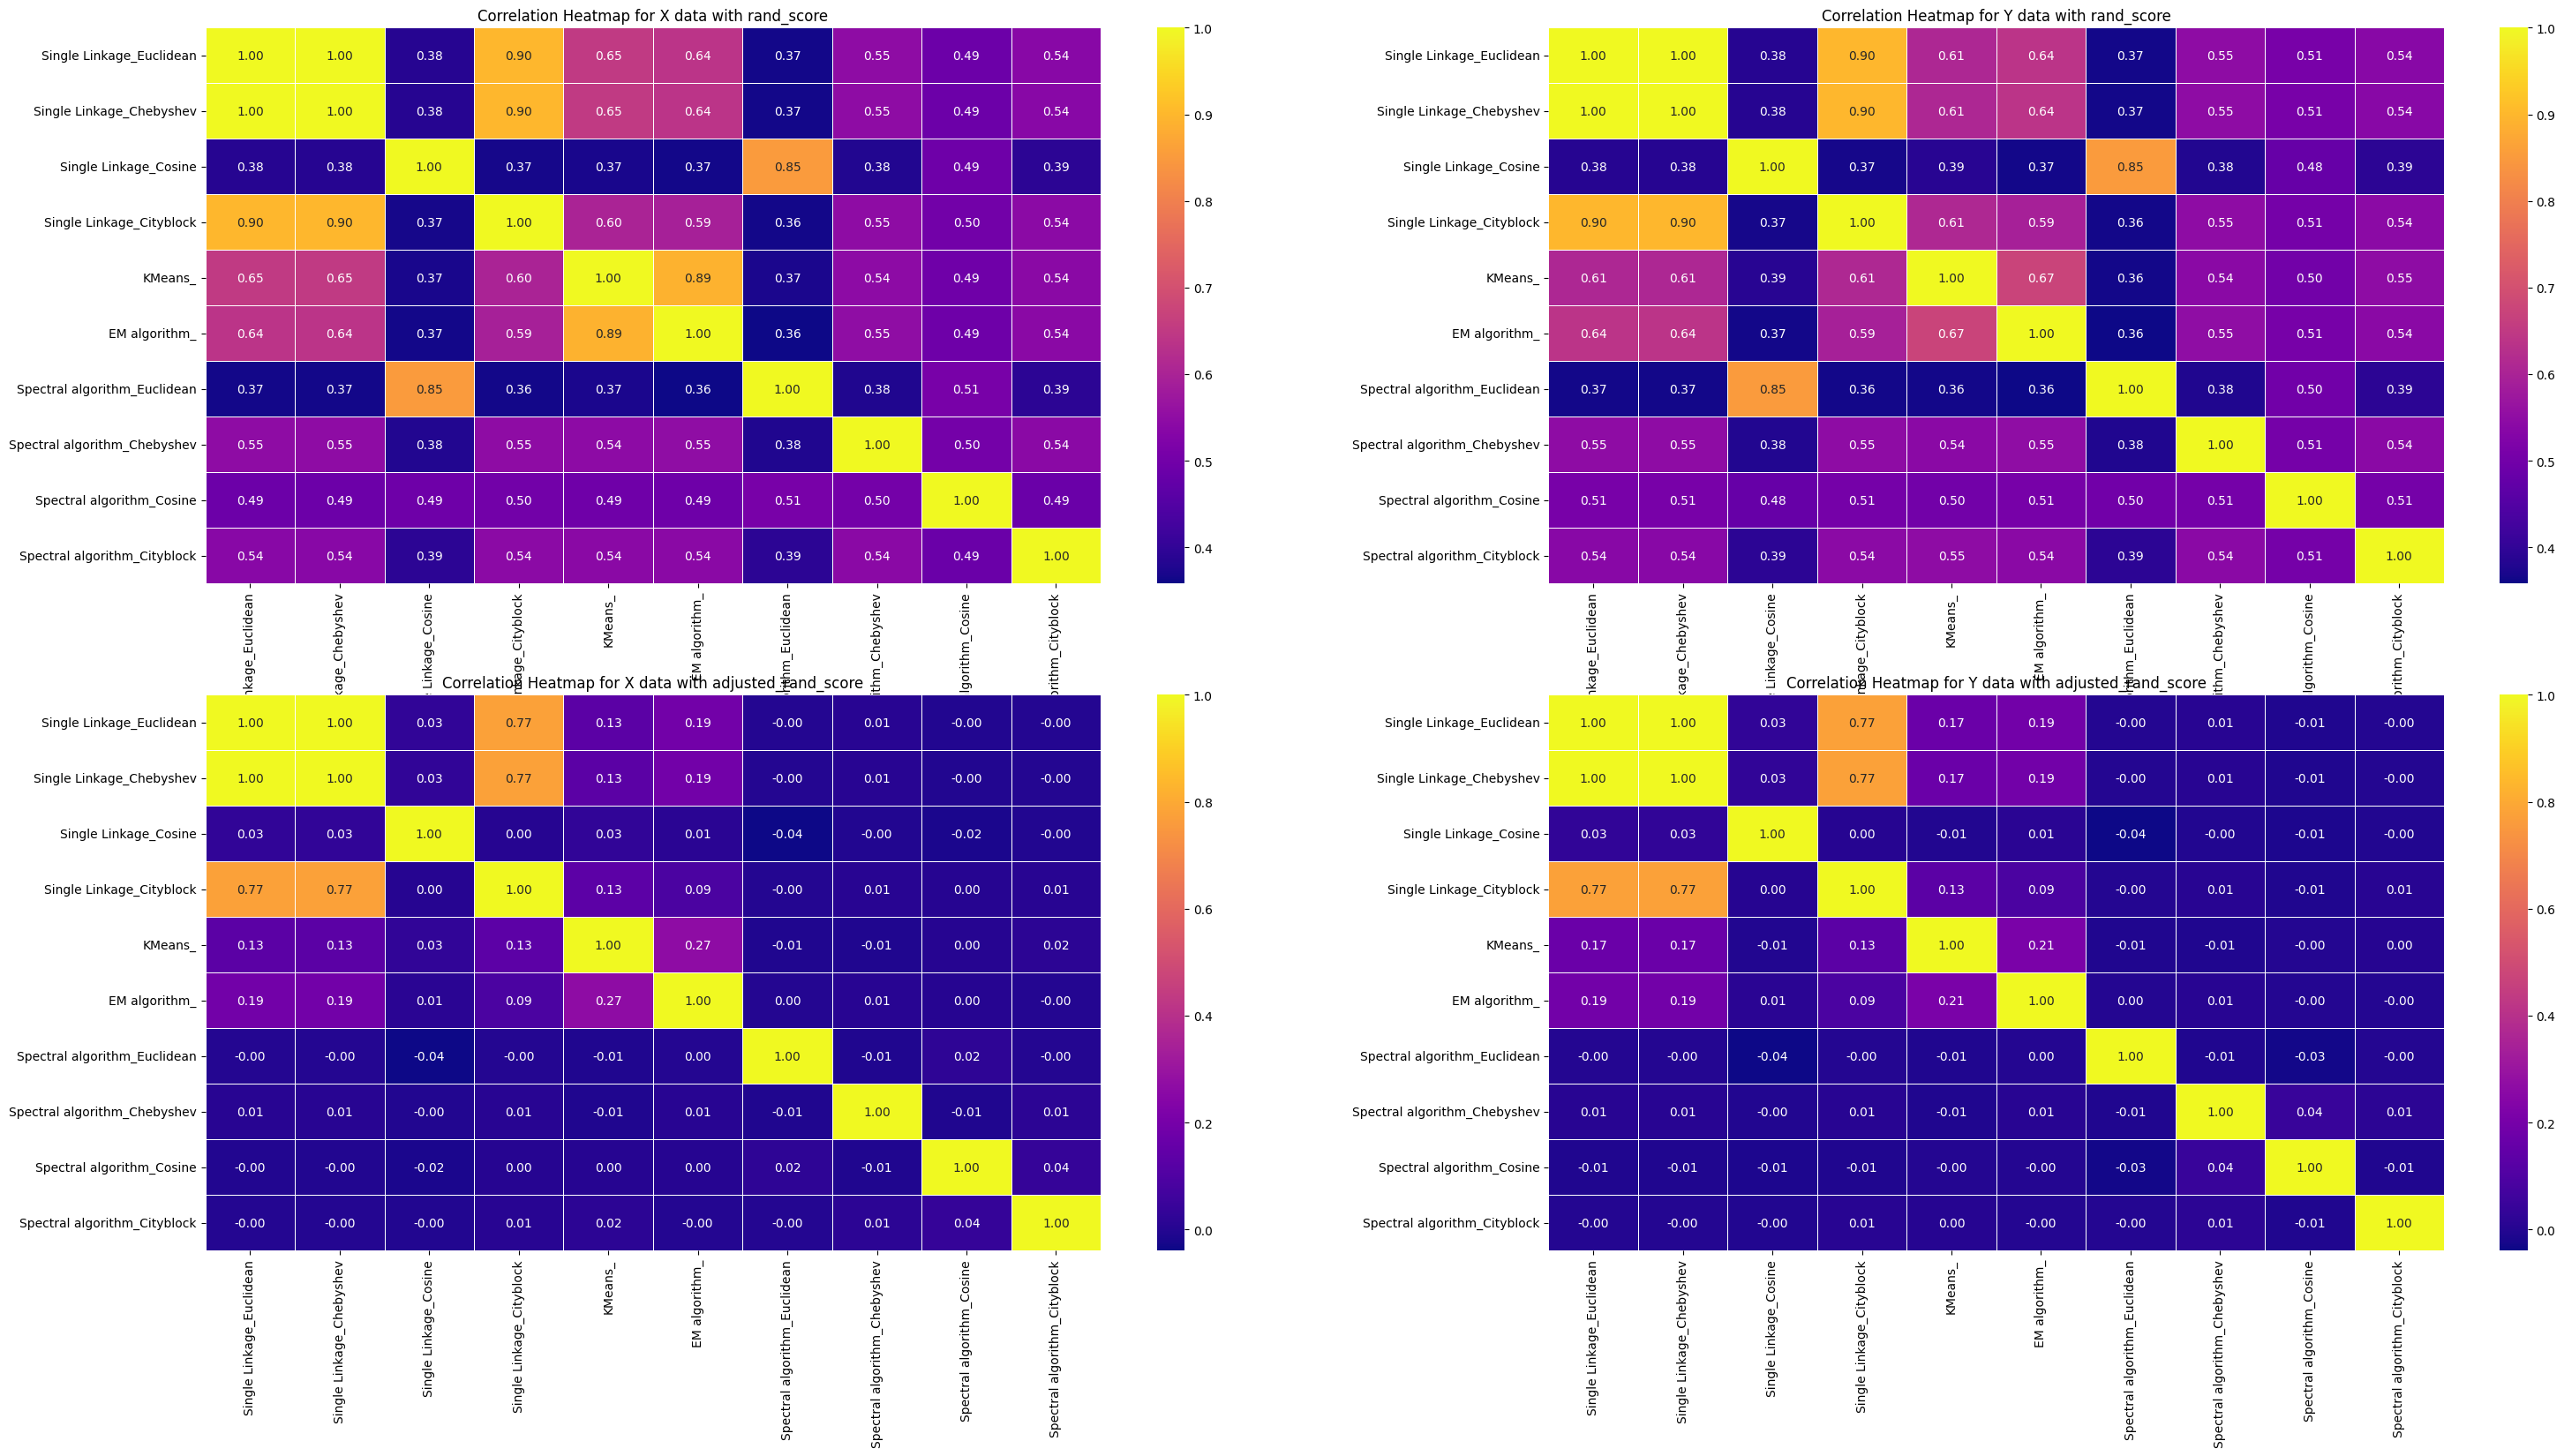

In [375]:
fig, axs = plt.subplots(2, 2, figsize=(36, 18))

statistic_x = calculate_rand_index(models_and_data, type_of_data='data_x')
statistic_x = statistic_x.apply(pd.to_numeric, errors='coerce')
sns.heatmap(statistic_x, cmap='plasma', ax=axs[0, 0], annot=True, fmt=".2f", linewidths=.5)
axs[0, 0].set_title('Correlation Heatmap for X data with rand_score')

statistic_y = calculate_rand_index(models_and_data, type_of_data='data_x')
statistic_y = statistic_y.apply(pd.to_numeric, errors='coerce')
sns.heatmap(statistic_y, cmap='plasma', ax=axs[0, 1], annot=True, fmt=".2f", linewidths=.5)
axs[0, 1].set_title('Correlation Heatmap for Y data with rand_score')

statistic_x_adg = calculate_rand_index(models_and_data, type_of_data='data_x', rand_function=adjusted_rand_score)
statistic_x_adg = statistic_x_adg.apply(pd.to_numeric, errors='coerce')
sns.heatmap(statistic_x_adg, cmap='plasma', ax=axs[1, 0], annot=True, fmt=".2f", linewidths=.5)
axs[1, 0].set_title('Correlation Heatmap for X data with adjusted_rand_score')

statistic_y_adg = calculate_rand_index(models_and_data, type_of_data='data_x', rand_function=adjusted_rand_score)
statistic_y_adg = statistic_y_adg.apply(pd.to_numeric, errors='coerce')
sns.heatmap(statistic_y_adg, cmap='plasma', ax=axs[1, 1], annot=True, fmt=".2f", linewidths=.5)
axs[1, 1].set_title('Correlation Heatmap for Y data with adjusted_rand_score')
pass

**Комментарий**: наиболее похожие алгоритмы - иерархический (Euclideanб Chebyshev, Cityblock), которые имеют схожесть равную примерно 1. Алгоритмы, такие как KMeans и EM algorithm, также имеют высокую схожесть, но ниже, чем идентичные пары. Ситауция похожая как и при k=2.

### 2.3 Вычислить значение функции модулярности для каждого разбиения на 3 кластера из п.2.1

In [376]:
def get_sets_of_classes(clusterization):
    partition = [set() for _ in range(len(np.unique(clusterization)))]
    for i in range(len(clusterization)):
        partition[clusterization[i]].add(i)
    return partition

def calculate_modularity(singularity_graphs, models_and_data, type_of_data):
    processed_clasterizartions = process_dict(models_and_data, type_of_data)

    for model_clusters in processed_clasterizartions.keys():
        communities = get_sets_of_classes(processed_clasterizartions[model_clusters])
        name_dist = model_clusters.split('_')[1]

        if name_dist not in singularity_graphs.keys():
          graph = singularity_graphs['Euclidean']
        else:
          graph = singularity_graphs[name_dist]
        processed_clasterizartions[model_clusters] = nx.community.modularity(graph, communities)
    return pd.DataFrame(processed_clasterizartions.values(), index=processed_clasterizartions.keys(), columns=['modularity'])

In [377]:
singularity_graphs_x = {'Euclidean': similarity_matrix_to_graph(similarity_euclidean_x),
                        'Chebyshev': similarity_matrix_to_graph(similarity_chebyshev_x),
                        'Cosine': similarity_matrix_to_graph(similarity_cosine_x),
                        'Cityblock': similarity_matrix_to_graph(similarity_cityblock_x)}
calculate_modularity(singularity_graphs_x, models_and_data, 'data_x')

modularity
Single Linkage_Euclidean        0.626779
Single Linkage_Chebyshev        0.627755
Single Linkage_Cosine           0.004076
Single Linkage_Cityblock        0.628006
KMeans_                         0.591955
EM algorithm_                   0.601368
Spectral algorithm_Euclidean    0.015967
Spectral algorithm_Chebyshev    0.054099
Spectral algorithm_Cosine      -0.001039
Spectral algorithm_Cityblock    0.001409

In [378]:
singularity_graphs_y = {'Euclidean': similarity_matrix_to_graph(similarity_euclidean_y),
                        'Chebyshev': similarity_matrix_to_graph(similarity_chebyshev_y),
                        'Cosine': similarity_matrix_to_graph(similarity_cosine_y),
                        'Cityblock': similarity_matrix_to_graph(similarity_cityblock_y)}
calculate_modularity(singularity_graphs_y, models_and_data, 'data_y')

modularity
Single Linkage_Euclidean        0.607259
Single Linkage_Chebyshev        0.619114
Single Linkage_Cosine           0.041594
Single Linkage_Cityblock        0.624065
KMeans_                         0.607259
EM algorithm_                   0.607259
Spectral algorithm_Euclidean    0.046664
Spectral algorithm_Chebyshev    0.006523
Spectral algorithm_Cosine      -0.001764
Spectral algorithm_Cityblock   -0.010231

**Комментарий**: в наборе данных X, иерархические алгоритмы (кроме косинусного) показывают наивысшую модулярность, что указывает на их хорошую производительность в кластеризации. В наборе данных Y также выделяются иерархические алгоритмы, особенно "Chebyshev" и "Cityblock", которые показывают схожие и высокие значения модулярности.

Spectral алгоритм имеет значительно более низкие или отрицательные значения модулярности, что указывает на их плохую производительность в данном контексте.

При увеличении числа кластеров с 2 до 3 показатель модулярности вырос для всех рассмотренных методов, для обоих наборов данных X и Y.

### 2.4 Сделать общие выводы по возможности разбиения на 3 кластера каждого набора данных.

**Набор данных X**:
Лучшие результаты визуально показала иерархическая кластаризация (single linkage) с Евклидовым, Манхэттенским, расстоянием Чебышева, что подтвердилось значением модулярности.

**Набор данных Y**:
Практически все методы продемонстрировали одинаковую кластеризацию на наборе данных Y. Модулярность увеличилась, визуализации показали, что данные Y требуют три кластера.

# 3. Общий случай.



Алгоритм Лувена (Louvain algorithm) — это популярный метод для выявления сообществ в графах. Он был предложен в 2008 году и стал одним из наиболее широко используемых алгоритмов для анализа сетевых структур благодаря своей эффективности и способности находить сообщества с высокой модульностью.

- На первом этапе каждый узел графа рассматривается как отдельное сообщество.

- Затем для каждого узла вычисляется, насколько выгодно переместить его в соседние сообщества. Это делается с использованием модулярности — метрики, которая измеряет плотность связей внутри сообществ по сравнению с ожидаемым количеством связей, если бы они распределялись случайным образом.

- Узел перемещается в то сообщество, которое приводит к наибольшему увеличению модулярности.

- После того как все узлы были перераспределены по сообществам, создается новый граф, где каждое сообщество представляется как один узел.

- Связи между этими новыми узлами определяются по количеству связей между узлами исходного графа, входящими в эти сообщества.

- Процесс повторяется с новым графом.

In [379]:
graphs_X = {'euclidean': similarity_matrix_to_graph(similarity_euclidean_x), 'chebyshev': similarity_matrix_to_graph(similarity_chebyshev_x), 'cosine': similarity_matrix_to_graph(similarity_cosine_x), 'cityblock': similarity_matrix_to_graph(similarity_cityblock_x) }
louvain_x = pd.DataFrame(columns=['Name', 'Count', 'Modularity'])
for graph in graphs_X.keys():
  result = nx.community.louvain_communities(graphs_X[graph])
  louvain_x.loc[len(louvain_x)] = [ graph, len(result), nx.community.modularity(graphs_X[graph], result)]

louvain_x

Name  Count  Modularity
0  euclidean     14    0.868692
1  chebyshev     15    0.878542
2     cosine      3    0.318096
3  cityblock     22    0.917170

In [380]:
graphs_Y = {'euclidean': similarity_matrix_to_graph(similarity_euclidean_y), 'chebyshev': similarity_matrix_to_graph(similarity_chebyshev_y), 'cosine': similarity_matrix_to_graph(similarity_cosine_y), 'cityblock': similarity_matrix_to_graph(similarity_cityblock_y) }
louvain_y = pd.DataFrame(columns=['Name', 'Count', 'Modularity'])
for graph in graphs_Y.keys():
  result = nx.community.louvain_communities(graphs_Y[graph])
  louvain_y.loc[len(louvain_y)] = [ graph, len(result), nx.community.modularity(graphs_Y[graph], result)]

louvain_y

Name  Count  Modularity
0  euclidean      3    0.607259
1  chebyshev      3    0.619114
2     cosine      2    0.048242
3  cityblock      3    0.624065

**Комментарий**: Алгоритм дает лучшую модулярность для Манхэттен графа и определяет 22 кластеров для X данных и 3 кластера для Y данных. Модулярность равна 0.91 и 0.62 соответственно. Данные Y алгоритм кластеризует на 3 группы, что согласуется с результатыми, полученными ранее с помощью других методов.

Также рассмотрим некоторые методы на основе алгоритма KMeans

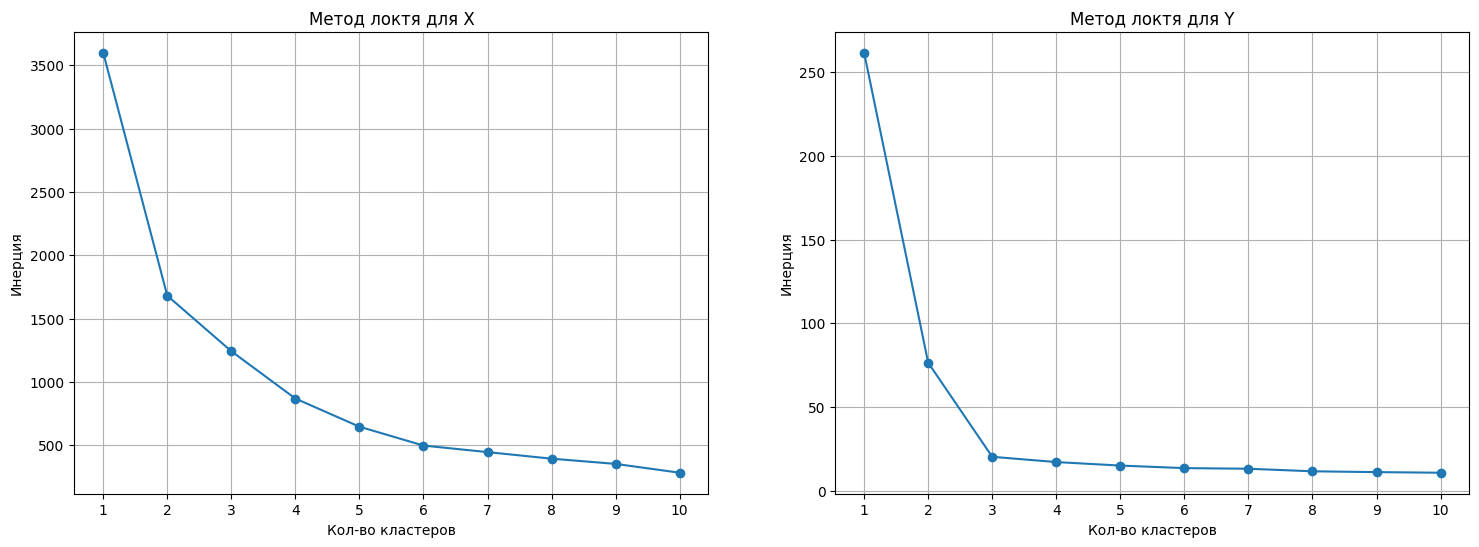

In [381]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

def calculate_elbow(dataset, K, i, type):
  inertia = []

  for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(np.array(dataset))
    inertia.append(kmeans.inertia_)

  axs[i].plot(K, inertia, marker='o')
  axs[i].set_title(f'Метод локтя для {type}')
  axs[i].set_xlabel('Кол-во кластеров')
  axs[i].set_ylabel('Инерция')
  axs[i].set_xticks(K)
  axs[i].grid()

calculate_elbow(df_x, K=range(1, 11), i=0, type='X')
calculate_elbow(df_y, K=range(1, 11), i=1, type='Y')

**Комментарий**: для поиска способа определения необходимого числа кластеров будем использовать метод "локтя". Этот метод включает в себя построение графика зависимости суммы квадратов расстояний (inertia) от числа кластеров (k). Следует выбирать значение k, при котором наблюдается "локоть" на графике, т.е. дальнейшее увеличение k не приводит к значительному снижению значения inertia.

Как мы видим из графика, для оптимальное количество X = 2, а для Y = 3 кластеров.

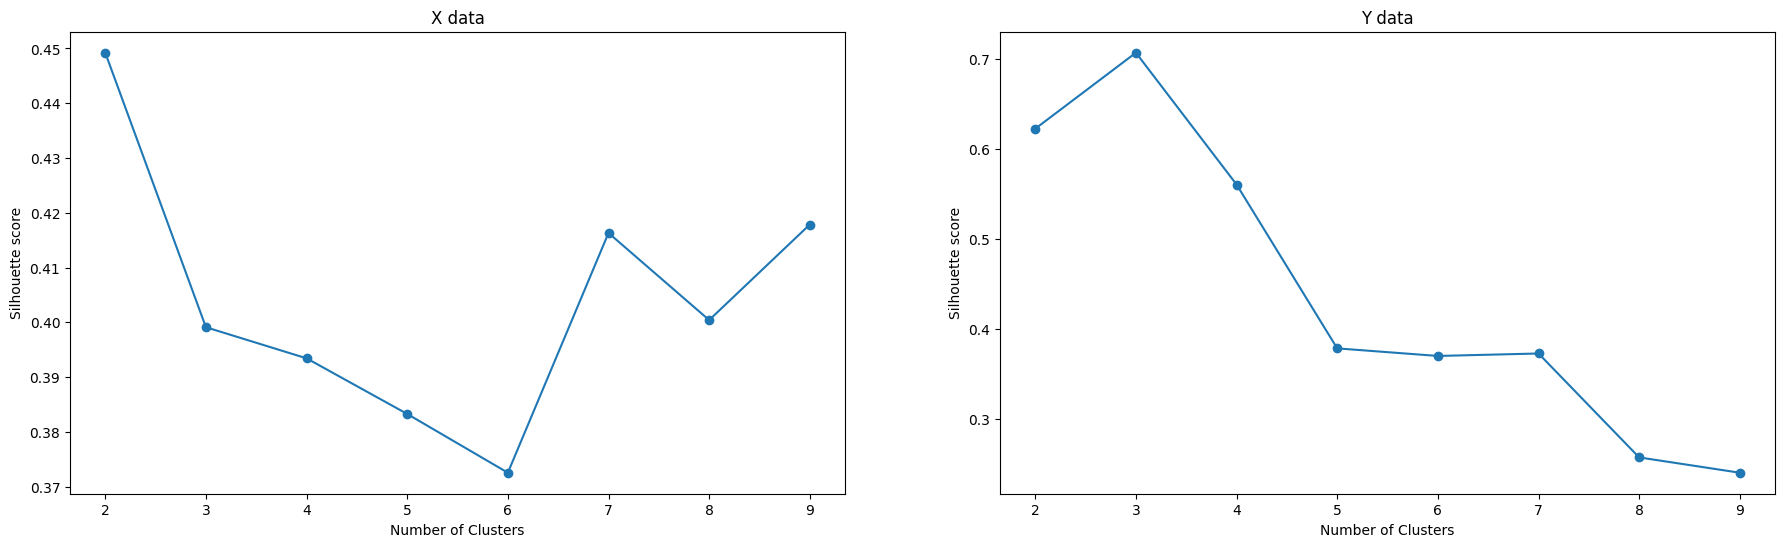

In [382]:
Silhouette_score_x = []
Silhouette_score_y = []
for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df_x)
    Silhouette_score_x.append(silhouette_score(df_x, kmeans.labels_))
for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df_y)
    Silhouette_score_y.append(silhouette_score(df_y, kmeans.labels_))
fig, axs = plt.subplots(1, 2, figsize=(22, 6))
axs[0].plot(range(2, 10), Silhouette_score_x, marker='o')
axs[0].set_title('X data')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette score')
axs[1].plot(range(2, 10), Silhouette_score_y, marker='o')
axs[1].set_title('Y data')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Silhouette score')
plt.show()

**Комментарий**: Silhouette Score — метод для оценивания качества кластеризации, этот инструмент предоставляет количественную меру того, насколько четко определены и различны кластеры.

Следовательно, чем выше данная метрика, тем кластеризация более корректная.
Данную оценку можно также использовать и для поиска оптимального количества кластеров.

Так, для набора данных X оптимальное количество кластеров 2 (так как именно в этом случае достигается наивысшее значение метрики), а для набора данных Y это число равно 3.

In [383]:
from sklearn.metrics import silhouette_score, silhouette_samples

def method_silhouette(algorithm, dist_name, data, df_save):
  model = algorithm['model']
  algorithm_name = algorithm['model_name']
  algorithm_type = algorithm['model_type']

  # data = np.array(data)
  cluster_labels = calculate_mode_fit_predict(model, data)
  if  data.shape[0] == data.shape[1]:
    silhouette_avg = silhouette_score(data, cluster_labels, metric='precomputed')
  else:
    silhouette_avg = silhouette_score(data, cluster_labels)
  df_save.loc[f"{algorithm_name}_{dist_name}", 'Silhouette score'] = round(silhouette_avg, 6)

  return df_save

Далее посчитаем метрику для всех алгоритмов

In [384]:
distances_names = ['Euclidean', 'Chebyshev', 'Cosine', 'Cityblock']

dist_x = [euclidean_x, chebyshev_x, cosine_x, cityblock_x]
dist_y = [euclidean_y, chebyshev_y, cosine_y, cityblock_y]

models_and_data = [
    {'model' : AgglomerativeClustering(n_clusters=2, linkage='single'),                                                                'data_x' : dist_x, 'data_y' : dist_y, 'model_type' : 'hierarchical',   'model_name' : 'Single Linkage'},
    {'model' : KMeans(n_clusters=2, n_init='auto', max_iter=300),                                                                      'data_x' : [df_x], 'data_y' : [df_y], 'model_type' : 'others',       'model_name' : 'KMeans'},
    {'model' : GaussianMixture(n_components=2, covariance_type='full', max_iter=300, init_params="random_from_data", random_state=42), 'data_x' : [df_x], 'data_y' : [df_y], 'model_type' : 'others',       'model_name' : 'EM algorithm'},
    {'model' : SpectralClustering(n_clusters=2, assign_labels='cluster_qr', affinity='precomputed'),                                   'data_x' : dist_x, 'data_y' : dist_y, 'model_type' : 'others',         'model_name' : 'Spectral algorithm'}
]

In [385]:
def calculate_silhouette(df_res, type):
  for model_dict in models_and_data:
    if len(model_dict[f'data_{type}']) == 1:
      # fig, ax = plt.subplots(1, 2, figsize=(18, 6))
      df_res = method_silhouette(algorithm=model_dict, dist_name='', data=model_dict[f'data_{type}'][0], df_save=df_res)
    else:
      for i, tar_df in enumerate(model_dict[f'data_{type}']):
        df_res = method_silhouette(algorithm=model_dict, dist_name=f'_{distances_names[i]}', data=tar_df, df_save=df_res)

  return df_res

In [386]:
pd_results_silhouette_x_2 = pd.DataFrame(columns=['Silhouette score'])

pd_results_silhouette_x_2 = calculate_silhouette(pd_results_silhouette_x_2, type='x')
pd_results_silhouette_x_2

Silhouette score
Single Linkage__Euclidean             0.046036
Single Linkage__Chebyshev             0.045803
Single Linkage__Cosine                0.426165
Single Linkage__Cityblock             0.046763
KMeans_                               0.448191
EM algorithm_                         0.411873
Spectral algorithm__Euclidean        -0.005842
Spectral algorithm__Chebyshev        -0.008555
Spectral algorithm__Cosine            0.046158
Spectral algorithm__Cityblock        -0.006466

In [387]:
n_clusters_by_shoulder = 2
pd_results_silhouette_y_2 = pd.DataFrame(columns=['Silhouette score'])

pd_results_silhouette_y_2 = calculate_silhouette(pd_results_silhouette_y_2, type='y')
pd_results_silhouette_y_2

Silhouette score
Single Linkage__Euclidean             0.593606
Single Linkage__Chebyshev             0.596264
Single Linkage__Cosine                0.875162
Single Linkage__Cityblock             0.599681
KMeans_                               0.622275
EM algorithm_                         0.593606
Spectral algorithm__Euclidean         0.095324
Spectral algorithm__Chebyshev        -0.008823
Spectral algorithm__Cosine           -0.026093
Spectral algorithm__Cityblock        -0.002305

In [388]:
models_and_data = [
    {'model' : AgglomerativeClustering(n_clusters=3, linkage='single'),                                                                'data_x' : dist_x, 'data_y' : dist_y, 'model_type' : 'hierarchical',   'model_name' : 'Single Linkage'},
    {'model' : KMeans(n_clusters=3, n_init='auto', max_iter=300),                                                                      'data_x' : [df_x], 'data_y' : [df_y], 'model_type' : 'others',       'model_name' : 'KMeans'},
    {'model' : GaussianMixture(n_components=3, covariance_type='full', max_iter=300, init_params="random_from_data", random_state=42), 'data_x' : [df_x], 'data_y' : [df_y], 'model_type' : 'others',       'model_name' : 'EM algorithm'},
    {'model' : SpectralClustering(n_clusters=3, assign_labels='cluster_qr', affinity='precomputed'),                                   'data_x' : dist_x, 'data_y' : dist_y, 'model_type' : 'others',         'model_name' : 'Spectral algorithm'}
]

In [389]:
pd_results_silhouette_x_3 = pd.DataFrame(columns=['Silhouette score'])

pd_results_silhouette_x_3 = calculate_silhouette(pd_results_silhouette_x_3, type='x')
pd_results_silhouette_x_3

Silhouette score
Single Linkage__Euclidean             0.167511
Single Linkage__Chebyshev             0.161707
Single Linkage__Cosine                0.385416
Single Linkage__Cityblock             0.152749
KMeans_                               0.391677
EM algorithm_                         0.378947
Spectral algorithm__Euclidean        -0.326455
Spectral algorithm__Chebyshev        -0.023471
Spectral algorithm__Cosine           -0.072716
Spectral algorithm__Cityblock        -0.031014

In [390]:
pd_results_silhouette_y_3 = pd.DataFrame(columns=['Silhouette score'])

pd_results_silhouette_y_3 = calculate_silhouette(pd_results_silhouette_y_3, type='y')
pd_results_silhouette_y_3

Silhouette score
Single Linkage__Euclidean             0.706723
Single Linkage__Chebyshev             0.693445
Single Linkage__Cosine                0.719947
Single Linkage__Cityblock             0.699334
KMeans_                               0.706723
EM algorithm_                         0.706723
Spectral algorithm__Euclidean        -0.243372
Spectral algorithm__Chebyshev        -0.050343
Spectral algorithm__Cosine           -0.176554
Spectral algorithm__Cityblock        -0.040498

**Комментарий**: Для Х в ситуации, когда данные делятся на два кластера можно отметить, что методы k-means, EM по данной оценке (Silhouette score) имеют наивысший показатель, это означает, что объекты в кластерах находятся ближе к другим объектам в своих же кластерах, чем к объектам из других кластеров, то есть кластеризация имеет ярко выраженные и отделимые кластеры.

Метод single linkage хорошо определили два кластера (по визуализации), но имеют не самое лучшее значение по данной метрике. Это можно объяснить тем, что набор данных X имеет вид "кольцеобразных данных", и в этом случае, объекты внутри кластеров могут быть близки друг к другу, но они также могут быть близки к объектам из других кластеров, что может привести к низкому значению Silhouette score.

В ситуации, когда данные делятся на три кластера, методы k-means и EM показывают лучший результат среди остальных, однако по сравнению с k = 2 метрика ухудшилась.

На Y данных результаты метрики (Silhouette score) выше.
В ситуации, когда данные делятся на два кластера наивысшее значение 0.87 для Single Linkage__Cosine. В ситуации, когда данные делятся на три кластера, все модели кроме Spectral имеют примерно одинаковое значение (0.70).